<center><h1> Accidents Corporels de la Route </h1></center>
<center> - </center>
<center> En France en 2017, Projet Data Visualization IGR204 </center>
<center> `Télécom ParisTech` </center>

# Imports

In [1]:
### General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

### Time Series
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import altair as alt 

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def set_color(data, col) :
    categories = np.unique(data[col])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))

    return data[col].apply(lambda x: colordict[x])

# The data

The data are avaialble on the French government's website.

In [3]:
veh = pd.read_csv('Accidents/vehicules_2005.csv')
usa = pd.read_csv('Accidents/usagers_2005.csv')
lie = pd.read_csv('Accidents/lieux_2005.csv')
car = pd.read_csv('Accidents/caracteristiques_2005.csv', encoding='latin-1')

#### 1) Véhicules impliqués dans l'accident

- `Num_Acc` : Identifiant de l’accident identique à celui du fichier "rubrique CARACTERISTIQUES" repris pour chacun des véhicules décrits impliqués dans l’accident
- `Num_Veh` : Identifiant du véhicule repris pour chacun des usagers occupant ce véhicule (y compris les piétons qui sont rattachés aux véhicules qui les ont heurtés) – Code alphanumérique
- `senc` : Sens de circulation :
    - 1 – PK ou PR ou numéro d’adresse postale croissant
    - 2 – PK ou PR ou numéro d’adresse postale décroissant
- `catv` : Catégorie du véhicule :
    - 01 - Bicyclette
    - 02 - Cyclomoteur <50cm3
    - 03 - Voiturette (Quadricycle à moteur carrossé) (anciennement "voiturette ou tricycle à moteur")
    - 04 - Référence plus utilisée depuis 2006 (scooter immatriculé)
    - 05 - Référence plus utilisée depuis 2006 (motocyclette)
    - 06 - Référence plus utilisée depuis 2006 (side-car)
    - 07 - VL seul
    - 08 - Catégorie plus utilisée (VL + caravane)
    - 09 - Catégorie plus utilisée (VL + remorque)
    - 10 - VU seul 1,5T <= PTAC <= 3,5T avec ou sans remorque (anciennement VU seul 1,5T <= PTAC <=3,5T)
    - 11 - Référence plus utilisée depuis 2006 (VU (10) + caravane)
    - 12 - Référence plus utilisée depuis 2006 (VU (10) + remorque)
    - 13 - PL seul 3,5T <PTCA <= 7,5T
    - 14 - PL seul > 7,5T
    - 15 - PL > 3,5T + remorque
    - 16 - Tracteur routier seul
    - 17 - Tracteur routier + semi-remorque
    - 18 - Référence plus utilisée depuis 2006 (transport en commun)
    - 19 - Référence plus utilisée depuis 2006 (tramway)
    - 20 - Engin spécial
    - 21 - Tracteur agricole
    - 30 - Scooter < 50 cm3
    - 31 - Motocyclette > 50 cm3 et <= 125 cm3
    - 32 - Scooter > 50 cm3 et <= 125 cm3
    - 33 - Motocyclette > 125 cm3
    - 34 - Scooter > 125 cm3
    - 35 - Quad léger <= 50 cm3 (Quadricycle à moteur non carrossé)
    - 36 - Quad lourd > 50 cm3 (Quadricycle à moteur non carrossé)
    - 37 - Autobus
    - 38 - Autocar
    - 39 - Train
    - 40 - Tramway
    - 99 - Autre véhicule
- `obs` : Obstacle fixe heurté :
    - 1 – Véhicule en stationnement
    - 2 – Arbre
    - 3 – Glissière métallique
    - 4 – Glissière béton
    - 5 – Autre glissière
    - 6 – Bâtiment, mur, pile de pont
    - 7 – Support de signalisation verticale ou poste d’appel d’urgence
    - 8 – Poteau
    - 9 – Mobilier urbain 
    - 10 – Parapet
    - 11 – Ilot, refuge, borne haute
    - 12 – Bordure de trottoir
    - 13 – Fossé, talus, paroi rocheuse
    - 14 – Autre obstacle fixe sur chaussée
    - 15 – Autre obstacle fixe sur trottoir ou accotement
    - 16 – Sortie de chaussée sans obstacle
- `obsm` : Obstacle mobile heurté :
    - 1 – Piéton
    - 2 – Véhicule
    - 4 – Véhicule sur rail
    - 5 – Animal domestique
    - 6 – Animal sauvage
    - 9 – Autre
- `choc` : Point de choc initial :
    - 1 - Avant
    - 2 – Avant droit
    - 3 – Avant gauche
    - 4 – Arrière
    - 5 – Arrière droit
    - 6 – Arrière gauche
    - 7 – Côté droit
    - 8 – Côté gauche
    - 9 – Chocs multiples (tonneaux)

In [4]:
veh.head()

Num_Acc  senc  catv  occutc  obs  obsm  choc  manv num_veh
0  200500000001     0     7       0    0     2     1     1     A01
1  200500000001     0     7       0    0     2     8    10     B02
2  200500000002     0     7       0    0     2     7    16     A01
3  200500000002     0     2       0    0     2     1     1     B02
4  200500000003     0     2       0    0     2     1     1     A01

In [5]:
print(len(veh))

149764


#### 2) Usagers 

- `Num_Acc` : Identifiant de l’accident identique à celui du fichier "rubrique CARACTERISTIQUES" repris pour chacun des usagers décrits impliqués dans l’accident
- `Num_Veh` :Identifiant du véhicule repris pour chacun des usagers occupant ce véhicule (y compris les piétons qui sont rattachés aux véhicules qui les ont heurtés) – Code alphanumérique 
- `place` : Permet de situer la place occupée dans le véhicule par l'usager au moment de l'accident
- `catu` : Catégorie d'usager :
    - 1 - Conducteur
    - 2 - Passager
    - 3 - Piéton
    - 4 - Piéton en roller ou en trottinette
- `grav` : Gravité de l'accident : Les usagers accidentés sont classés en trois catégories de victimes plus les indemnes
    - 1 - Indemne
    - 2 - Tué
    - 3 - Blessé hospitalisé
    - 4 - Blessé léger
- `sexe` : Sexe de l'usager
    - 1 - Masculin
    - 2 – Féminin
- `An_nais` : Année de naissance de l'usager
- `trajet` : Motif du déplacement au moment de l’accident :
    - 1 – Domicile – travail
    - 2 – Domicile – école
    - 3 – Courses – achats
    - 4 – Utilisation professionnelle
    - 5 – Promenade – loisirs
    - 9 – Autre 
- `secu` : sur 2 caractères : 
    - le premier concerne l’existence d’un Équipement de sécurité
        - 1 – Ceinture
        - 2 – Casque
        - 3 – Dispositif enfants
        - 4 – Equipement réfléchissant
        - 9 – Autre
    - le second concerne l’utilisation de l’Équipement de sécurité
         - 1 – Oui
         - 2 – Non
         - 3 – Non déterminable
- `locp` : Localisation du piéton :
    - Sur chaussée :
        - 1 – A + 50 m du passage piéton
        - 2 – A – 50 m du passage piéton
    - Sur passage piéton :
        - 3 – Sans signalisation lumineuse
        - 4 – Avec signalisation lumineuse
    - Divers :
        - 5 – Sur trottoir
        - 6 – Sur accotement
        - 7 – Sur refuge ou BAU
        - 8 – Sur contre allée

In [6]:
usa.head()

Num_Acc  place  catu  grav  sexe  trajet  secu  locp  actp  etatp  \
0  200500000001      1     1     4     1       1    11     0     0      0   
1  200500000001      1     1     3     2       3    11     0     0      0   
2  200500000001      2     2     1     1       0    11     0     0      0   
3  200500000001      4     2     1     1       0    31     0     0      0   
4  200500000001      5     2     1     1       0    11     0     0      0   

   an_nais num_veh  
0   1976.0     A01  
1   1968.0     B02  
2   1964.0     B02  
3   2004.0     B02  
4   1998.0     B02

#### 3) Lieux de l'accident

- `Num_Acc` : Identifiant de l’accident identique à celui du fichier "rubrique CARACTERISTIQUES" repris dans l’accident
- `catr` : Catégorie de route :
    - 1 - Autoroute
    - 2 - Route Nationale
    - 3 - Route Départementale
    - 4 - Voie Communale
    - 5 - Hors réseau public
    - 6 - Parc de stationnement ouvert à la circulation publique
    - 9 – autre
- `circ` : Régime de circulation :
    - 1 – A sens unique
    - 2 – Bidirectionnelle
    - 3 – A chaussées séparées
    - 4 – Avec voies d’affectation variable
- `nbv` : Nombre total de voies de circulation 
- `vosp` : Signale l’existence d’une voie réservée, indépendamment du fait que l’accident ait lieu ou non sur cette voie.
    - 1 – Piste cyclable
    - 2 – Banque cyclable
    - 3 – Voie réservée
- `prof` : Profil en long décrit la déclivité de la route à l'endroit de l'accident
    - 1 - Plat
    - 2 - Pente
    - 3 - Sommet de côte
    - 4 - Bas de côte
- `plan`: Tracé en plan :
    - 1 – Partie rectiligne
    - 2 – En courbe à gauche
    - 3 – En courbe à droite
    - 4 – En « S »
- `lartpc` : Largeur du terre plein central (TPC) s'il existe
- `larrout` : Largeur de la chaussée affectée à la circulation des véhicules, ne sont pas compris les bandes d'arrêt d'urgence, les TPC et les places de stationnement
- `surf` : Etat de la surface
    - 1 - normale
    - 2 - mouillée
    - 3 - flaques
    - 4 - inondée
    - 5 - enneigée
    - 6 - boue
    - 7 - verglacée
    - 8 - corps gras - huile
    - 9 - autre
- `infra` : Aménagement - Infrastructure :
    - 1 – Souterrain - tunnel
    - 2 – Pont - autopont
    - 3 – Bretelle d’échangeur ou de raccordement
    - 4 - Voie ferrée
    - 5 – Carrefour aménagé
    - 6 – Zone piétonne
    - 7 – Zone de péage
- `situ` : Situation de l’accident :
    - 1 – Sur chaussée
    - 2 – Sur bande d’arrêt d’urgence
    - 3 – Sur accotement
    - 4 – Sur trottoir
    - 5 – Sur piste cyclable
- `env1` : point école : proximité d'une école 

In [7]:
lie.head()

Num_Acc  catr   voie   v1   v2  circ  nbv    pr    pr1  vosp  prof  \
0  200500000001   3.0   41.0  0.0    B     2    2   1.0  430.0     0     1   
1  200500000002   2.0   41.0  0.0  NaN     0    2   0.0    0.0     1     1   
2  200500000003   2.0   41.0  0.0  NaN     0    0   0.0    0.0     1     1   
3  200500000004   3.0  916.0  0.0  NaN     2    2   0.0    0.0     0     1   
4  200500000005   3.0  110.0  0.0  NaN     2    2  24.0  630.0     0     1   

   plan  lartpc  larrout  surf  infra  situ  env1  
0     1       0       63     1      0     1     0  
1     1       0      100     1      0     5     0  
2     1       0        0     2      0     5     0  
3     1       0        0     1      0     1     0  
4     3       0       59     2      0     3     0

#### 4) Caractéristiques de l'accident

- `Num_Acc` : Numéro d'identifiant de l’accident
- `jour` : Jour de l'accident
- `mois` : Mois de l'accident
- `an` : Année de l'accident
- `hrmn` : Heure et minutes de l'accident
- `lum` : Lumière : conditions d’éclairage dans lesquelles l'accident s'est produit
    - 1 – Plein jour
    - 2 – Crépuscule ou aube
    - 3 – Nuit sans éclairage public
    - 4 - Nuit avec éclairage public non allumé
    - 5 – Nuit avec éclairage public allumé
- `dep` : Département : Code INSEE (Institut National de la Statistique et des Etudes Economiques) du département suivi d'un 0 (201 Corse-du-Sud - 202 Haute-Corse)
- `com` : Commune : Le numéro de commune est un code donné par l‘INSEE. Le code comporte 3 chiffres calés à droite.
- `agg` : Localisation :
    - 1 – Hors agglomération
    - 2 – En agglomération
- `atm` : Conditions atmosphériques :
    - 1 – Normale
    - 2 – Pluie légère
    - 3 – Pluie forte
    - 4 – Neige - grêle
    - 5 – Brouillard - fumée
    - 6 – Vent fort - tempête
    - 7 – Temps éblouissant
    - 8 – Temps couvert
    - 9 – Autre
- `col` : Type de collision : A remplacer par nombre d'usagers impliqués (group by num_acc / usager)
- `gps` : Codage GPS :1 caractère indicateur de provenance :
    - M = Métropole
    - A = Antilles (Martinique ou Guadeloupe)
    - G = Guyane
    - R = Réunion
    - Y = Mayotte
- Coordonnées géographiques en degrés décimaux :
     - lat : Latitude
     - long : Longitude 

In [8]:
car.head()

Num_Acc  an  mois  jour  hrmn  lum  agg  int  atm  col    com  \
0  200500000001   5     1    12  1900    3    2    1    1    3   11.0   
1  200500000002   5     1    21  1600    1    2    1    1    1   51.0   
2  200500000003   5     1    21  1845    3    1    1    2    1   51.0   
3  200500000004   5     1     4  1615    1    1    1    1    5   82.0   
4  200500000005   5     1    10  1945    3    1    1    3    6  478.0   

            adr gps        lat      long  dep  
0         CD41B   M  5051500.0  294400.0  590  
1  rue de Lille   M  5053700.0  280200.0  590  
2           NaN   M  5054600.0  280000.0  590  
3           NaN   M  5098700.0  240800.0  590  
4           NaN   M  5096400.0  247500.0  590

In [9]:
print(car.shape)
(car['lat'] == 0).astype(int).sum(axis=0)

(87026, 16)


14868

# Load yearly data

In [10]:
for i in range(2006,2018,1) :
    lie = pd.concat([lie, pd.read_csv('Accidents/lieux_' + str(i) + '.csv')], axis=0)
    usa = pd.concat([usa, pd.read_csv('Accidents/usagers_' + str(i) + '.csv')], axis=0)
    veh = pd.concat([veh, pd.read_csv('Accidents/vehicules_' + str(i) + '.csv')], axis=0)
    try : 
        car = pd.concat([car, pd.read_csv('Accidents/caracteristiques_' + str(i) + '.csv', encoding='latin-1')], axis=0)
    except :
        car = pd.concat([car, pd.read_csv('Accidents/caracteristiques_' + str(i) + '.csv', encoding='latin-1', sep = '\t')], axis=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
print(len(lie))
print(len(car))
print(len(veh))
print(len(usa))

900686
900686
1536935
2012026


# Data Visualization

## 1. Vehicules

#### Descriptive statistics and distributions

In [12]:
veh.describe()

Num_Acc          senc          catv        occutc           obs  \
count  1.536935e+06  1.536795e+06  1.536935e+06  1.536935e+06  1.536118e+06   
mean   2.010473e+11  1.725227e-01  1.154704e+01  7.542804e-02  9.118180e-01   
std    3.776397e+08  4.833081e-01  1.128024e+01  2.055817e+00  2.988024e+00   
min    2.005000e+11  0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
25%    2.007001e+11  0.000000e+00  7.000000e+00  0.000000e+00  0.000000e+00   
50%    2.010000e+11  0.000000e+00  7.000000e+00  0.000000e+00  0.000000e+00   
75%    2.014000e+11  0.000000e+00  1.000000e+01  0.000000e+00  0.000000e+00   
max    2.017001e+11  2.000000e+00  9.900000e+01  7.000000e+02  1.600000e+01   

               obsm          choc          manv  
count  1.536292e+06  1.536671e+06  1.536599e+06  
mean   1.578564e+00  2.893666e+00  6.019138e+00  
std    1.235419e+00  2.466560e+00  7.171478e+00  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    1.000000e+00  1.000000e+00  1.000000e+00  
50%    2.000000e+00  2.000000e+00  1.000000e+00  
75%    2.000000e+00  4.000000e+00  1.300000e+01  
max    9.000000e+00  9.000000e+00  2.400000e+01

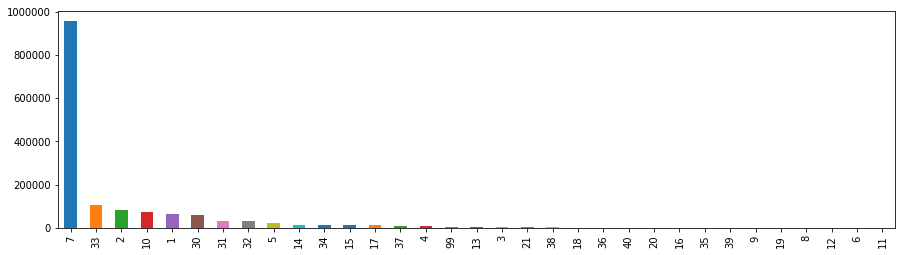

In [13]:
# Type of vehicle implied in accident
plt.figure(figsize=(15,4))
veh['catv'].value_counts().plot.bar()
plt.show()

**TOP 5 Vehicles**

- 7 : VL seul
- 33 : Motocyclette > 125 cm3
- 2 : Cyclomoteur < 50cm3
- 10 : VU seul 1,5T <= PTAC <= 3,5T
- 1 : Bicyclette

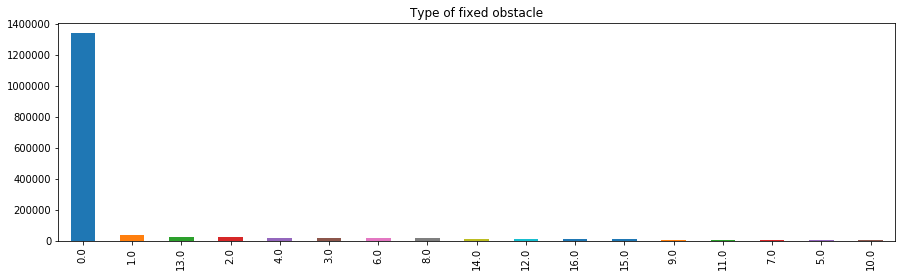

In [14]:
# Type of fixed obstacle implied in the accident
plt.figure(figsize=(15,4))
veh['obs'].value_counts().plot.bar()
plt.title('Type of fixed obstacle')
plt.show()

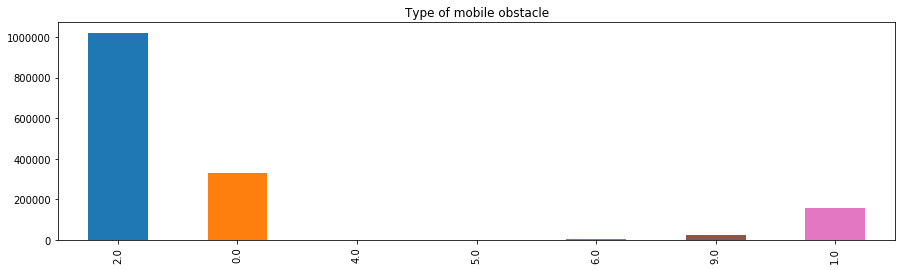

In [15]:
# Type of mobile obstacle implied in the accident
plt.figure(figsize=(15,4))
veh['obsm'].value_counts(sort=False).plot.bar()
plt.title('Type of mobile obstacle')
plt.show()

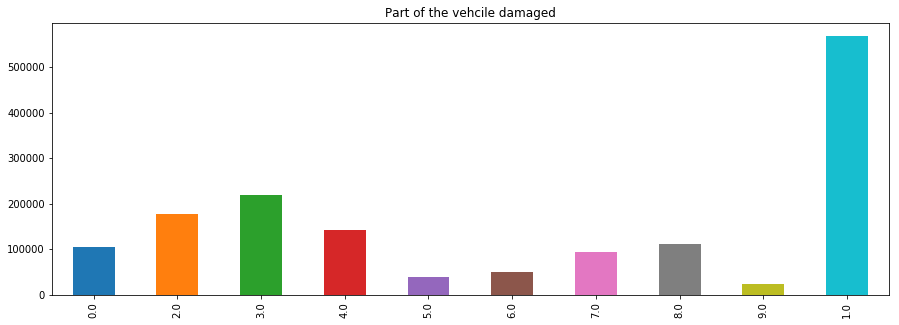

In [16]:
# Part of the vehicle damaged
plt.figure(figsize=(15,5))
veh['choc'].value_counts(sort=False).plot.bar()
plt.title('Part of the vehcile damaged')
plt.show()

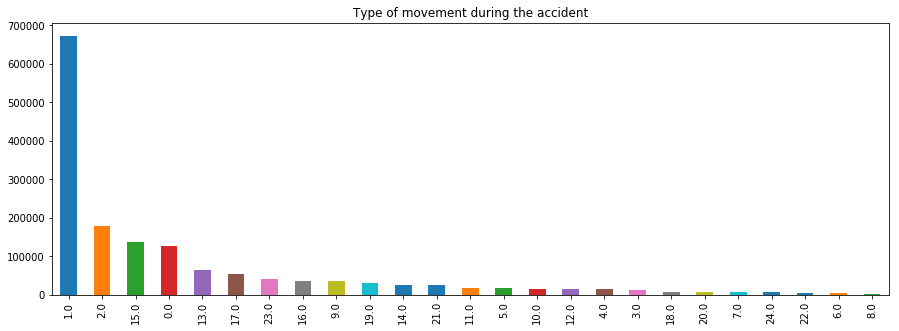

In [17]:
# Type of movement
plt.figure(figsize=(15,5))
veh['manv'].value_counts().plot.bar()
plt.title('Type of movement during the accident')
plt.show()

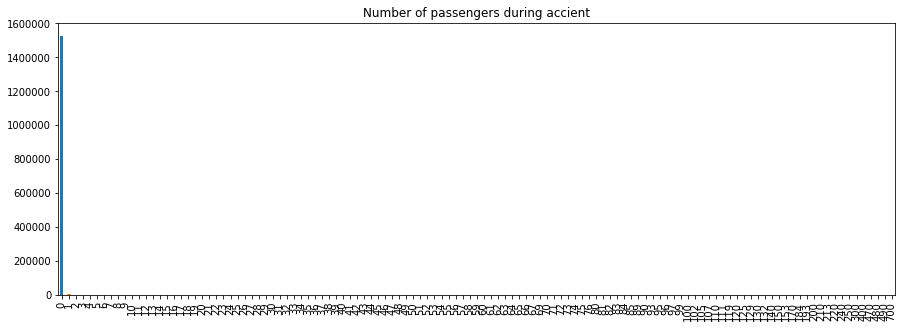

In [18]:
# Number of passengers
plt.figure(figsize=(15,5))
veh['occutc'].value_counts(sort=False).plot.bar()
plt.title('Number of passengers during accient')
plt.show()

#### Further Data Visualization

##### Number of vehicle implied

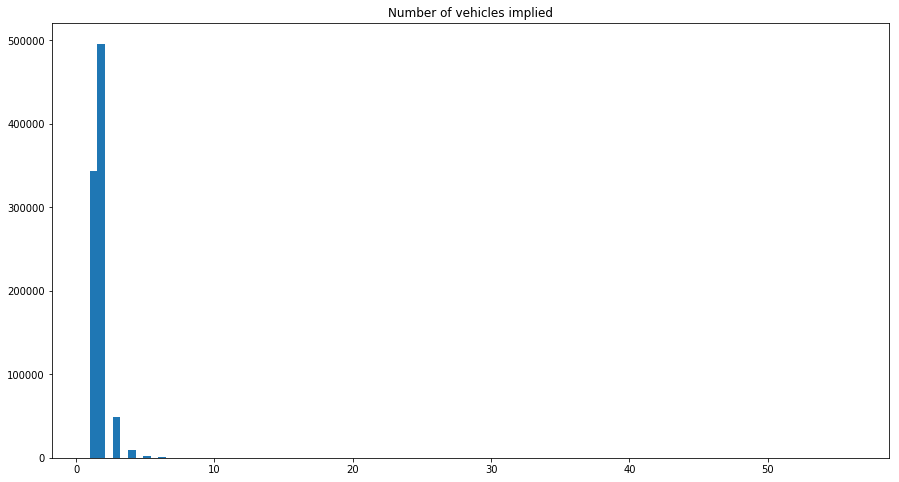

In [19]:
# Number of vehicles implied
veh['nb'] = 1

plt.figure(figsize=(15,8))
plt.hist(veh.groupby('Num_Acc').sum()['nb'], bins = 100)
plt.title('Number of vehicles implied')
plt.show()

## 2. Usagers

#### Descriptive statistics and distributions

In [20]:
usa.describe()

Num_Acc         place          catu          grav          sexe  \
count  2.012026e+06  1.899858e+06  2.012026e+06  2.012026e+06  2.012026e+06   
mean   2.010466e+11  1.293546e+00  1.341978e+00  2.511713e+00  1.328488e+00   
std    3.779721e+08  9.359688e-01  6.338804e-01  1.332615e+00  4.696634e-01   
min    2.005000e+11  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.007001e+11  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
50%    2.010000e+11  1.000000e+00  1.000000e+00  3.000000e+00  1.000000e+00   
75%    2.014000e+11  1.000000e+00  2.000000e+00  4.000000e+00  2.000000e+00   
max    2.017001e+11  9.000000e+00  4.000000e+00  4.000000e+00  2.000000e+00   

             trajet          secu          locp          actp         etatp  \
count  2.011646e+06  1.959618e+06  2.010316e+06  2.010210e+06  2.010254e+06   
mean   3.102648e+00  1.819843e+01  2.246801e-01  2.766592e-01  1.025423e-01   
std    2.676165e+00  1.965117e+01  8.722731e-01  1.051886e+00  3.799410e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  1.100000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
50%    4.000000e+00  1.100000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
75%    5.000000e+00  2.100000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
max    9.000000e+00  9.300000e+01  8.000000e+00  9.000000e+00  3.000000e+00   

            an_nais  
count  2.009638e+06  
mean   1.973064e+03  
std    1.843600e+01  
min    1.896000e+03  
25%    1.961000e+03  
50%    1.976000e+03  
75%    1.987000e+03  
max    2.017000e+03

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


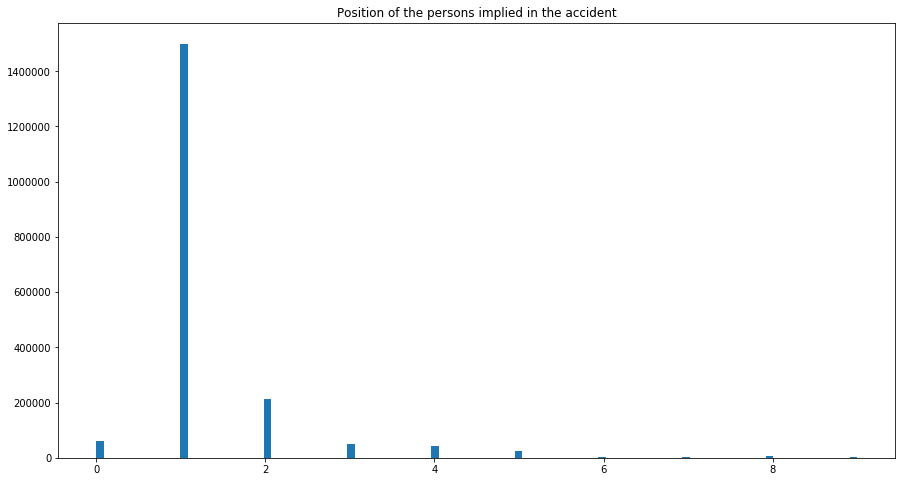

In [21]:
# Position of the persons implied in the accident within the vehicle
plt.figure(figsize=(15,8))
plt.hist(usa['place'], bins=100)
plt.title('Position of the persons implied in the accident')
plt.show()

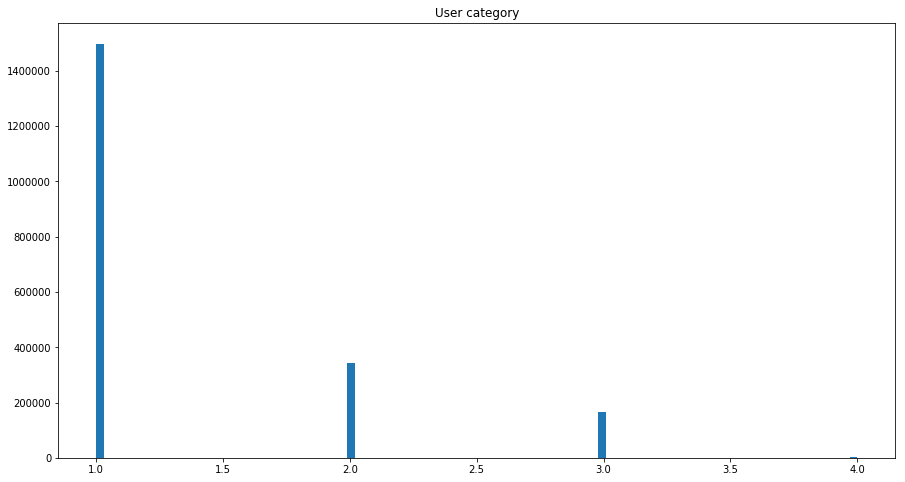

In [22]:
# User Category
plt.figure(figsize=(15,8))
plt.hist(usa['catu'], bins=100)
plt.title('User category')
plt.show()

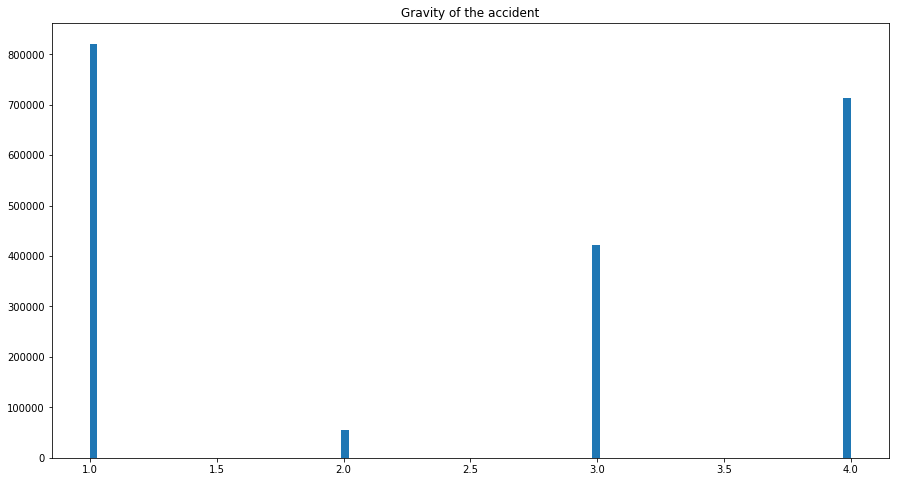

In [23]:
# Accident gravity
plt.figure(figsize=(15,8))
plt.hist(usa['grav'], bins=100)
plt.title('Gravity of the accident')
plt.show()

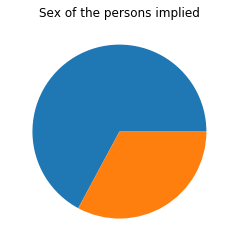

In [24]:
plt.figure(figsize=(15,4))
plt.pie(usa['sexe'].value_counts())
plt.title('Sex of the persons implied')
plt.show()

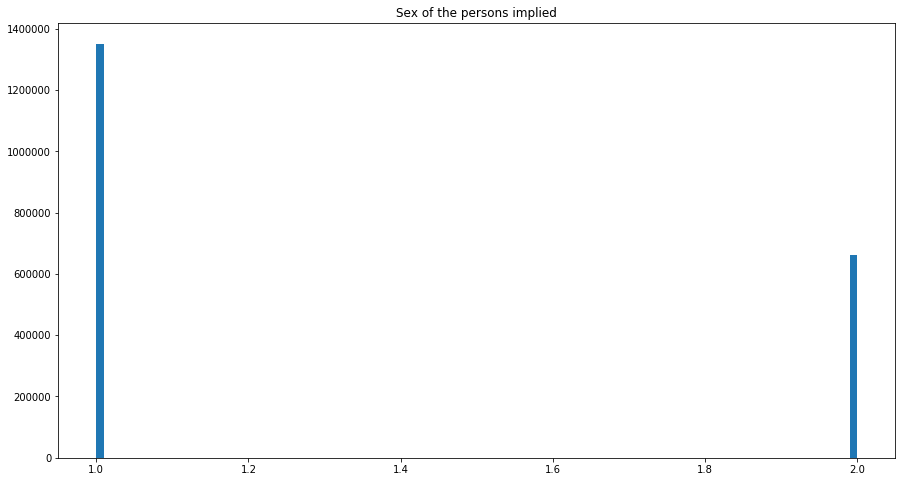

In [25]:
# Sex of persons implied
plt.figure(figsize=(15,8))
plt.hist(usa['sexe'], bins=100)
plt.title('Sex of the persons implied')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


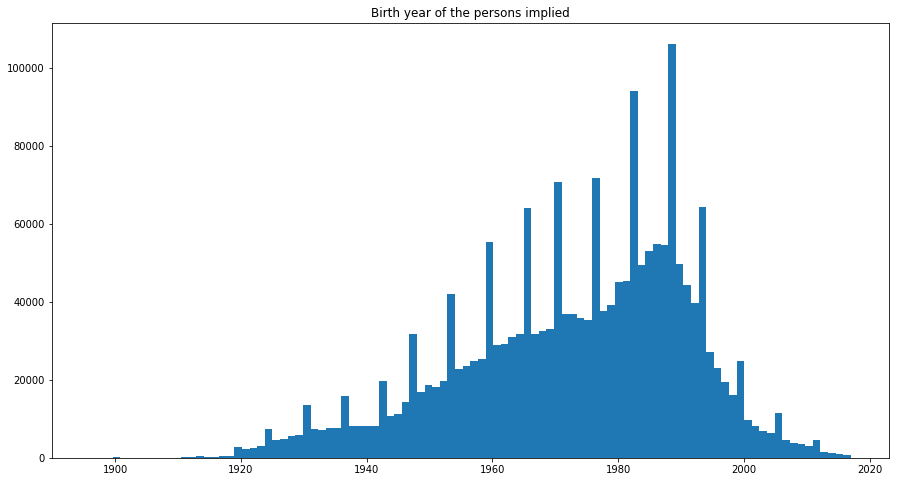

In [26]:
# Birth year
plt.figure(figsize=(15,8))
plt.hist(usa['an_nais'], bins=100)
plt.title('Birth year of the persons implied')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


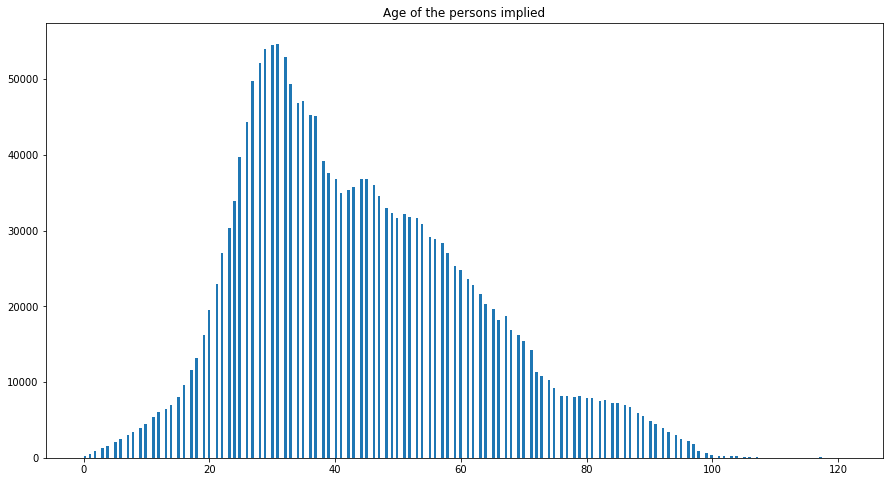

In [27]:
# Age of the persons implied
usa['age'] = 2017 - usa['an_nais']
fig = plt.figure(figsize=(15,8))
plt.hist(usa['age'], bins=300)
plt.title('Age of the persons implied')
plt.show()

In [28]:
chart = alt.Chart(usa.sample(4999)).mark_bar().encode(
    alt.X("age:Q", bin=alt.Bin(maxbins=100), axis=alt.Axis(title='Age')),
    y='count()',
    tooltip=[alt.Tooltip('count()', title="Total")],
).properties(
    title='Age of the victims'
)

chart.save('histo_age.html')

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


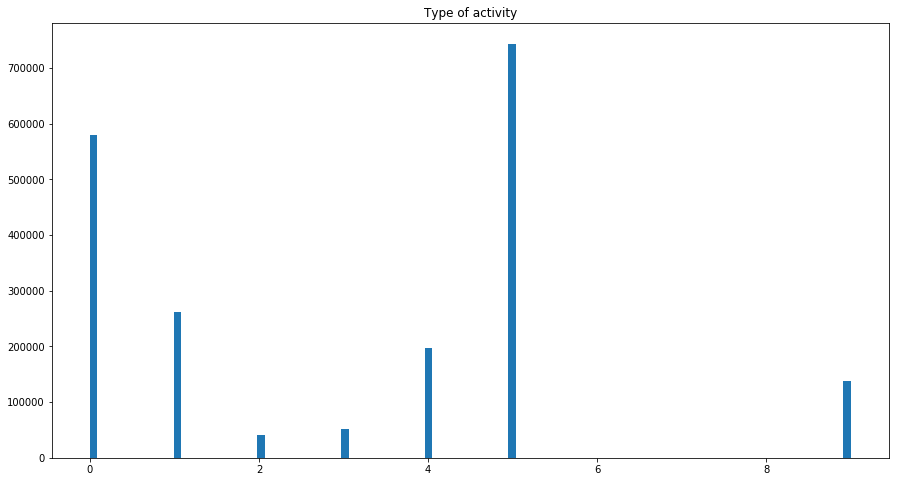

In [29]:
# Type of acitvity of the users
plt.figure(figsize=(15,8))
plt.hist(usa['trajet'], bins=100)
plt.title('Type of activity')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


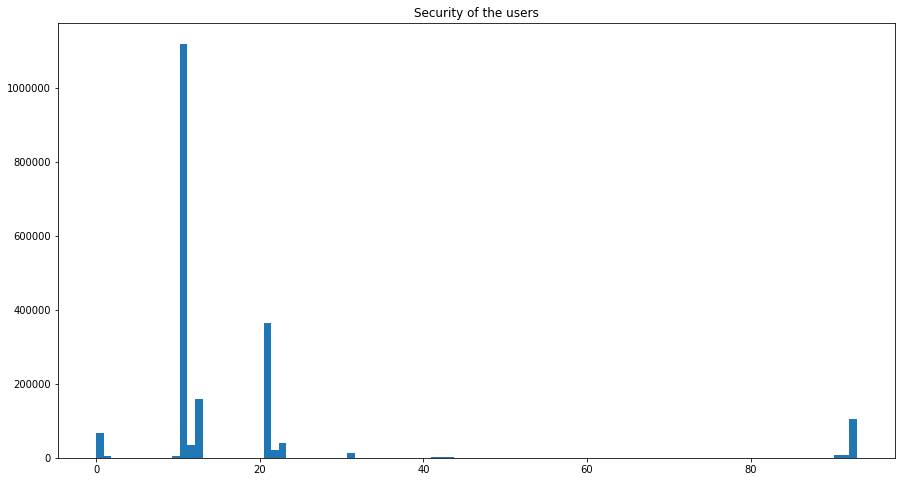

In [30]:
# Security of the users
plt.figure(figsize=(15,8))
plt.hist(usa['secu'], bins=100)
plt.title('Security of the users')
plt.show()

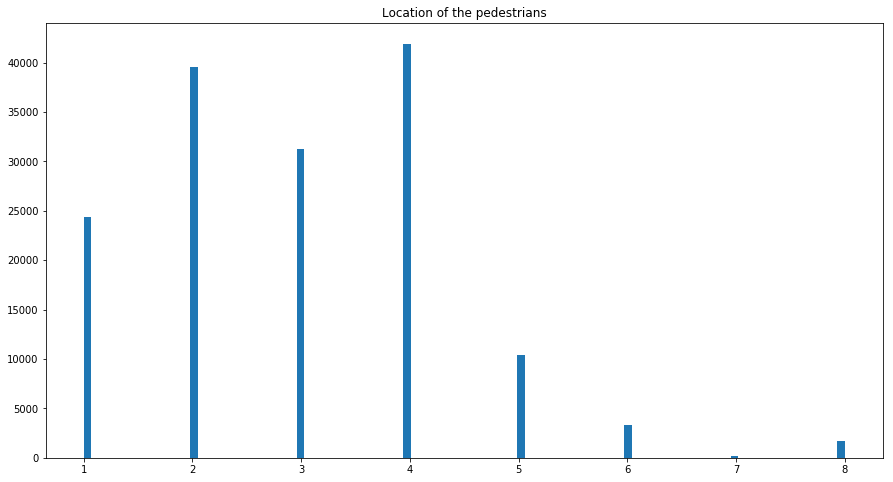

In [31]:
# Location of the pedestrians
plt.figure(figsize=(15,8))
plt.hist(usa[usa['locp']>0]['locp'], bins=100)
plt.title('Location of the pedestrians')
plt.show()

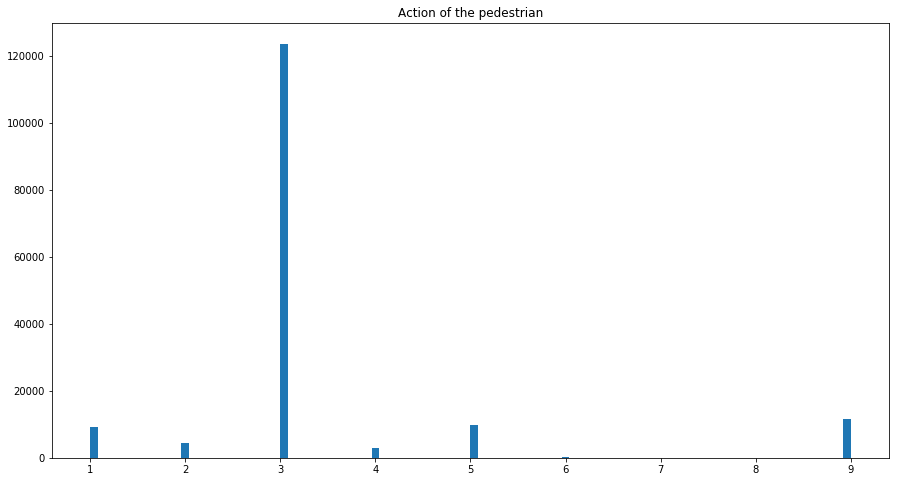

In [32]:
# Action of the pedestrian
plt.figure(figsize=(15,8))
plt.hist(usa[usa['actp']>0]['actp'], bins=100)
plt.title('Action of the pedestrian')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


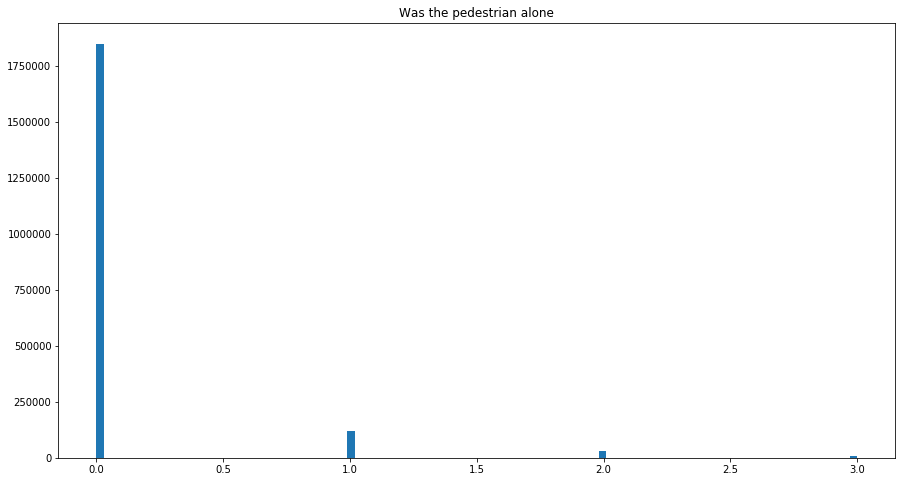

In [33]:
# Was the pedestrian alone ?
plt.figure(figsize=(15,8))
plt.hist(usa['etatp'], bins=100)
plt.title('Was the pedestrian alone')
plt.show()

## 3. Location

In [34]:
lie.describe()

Num_Acc           catr             v1           circ  \
count  9.006860e+05  900685.000000  333224.000000  899517.000000   
mean   2.010482e+11       3.410619       0.071027       1.856490   
std    3.771189e+08       1.204437       0.571669       0.720311   
min    2.005000e+11       1.000000       0.000000       0.000000   
25%    2.007001e+11       3.000000       0.000000       2.000000   
50%    2.010000e+11       4.000000       0.000000       2.000000   
75%    2.014000e+11       4.000000       0.000000       2.000000   
max    2.017001e+11       9.000000       9.000000       4.000000   

                 nbv             pr            pr1           vosp  \
count  898462.000000  440977.000000  439431.000000  898450.000000   
mean        2.049557     105.110233     282.805464       0.130801   
std         1.530859     484.987130     358.121398       0.555635   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       0.000000       0.000000   
50%         2.000000       6.000000     100.000000       0.000000   
75%         2.000000      28.000000     500.000000       0.000000   
max        99.000000    9900.000000    9540.000000       3.000000   

                prof           plan         lartpc        larrout  \
count  899176.000000  898825.000000  888978.000000  890387.000000   
mean        1.139814       1.194182       5.333336      58.222338   
std         0.617196       0.725390      23.127979      64.734582   
min         0.000000       0.000000       0.000000     -81.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000      60.000000   
75%         1.000000       1.000000       0.000000      80.000000   
max         4.000000       4.000000     960.000000     999.000000   

                surf          infra           situ           env1  
count  899204.000000  895744.000000  896210.000000  895705.000000  
mean        1.257186       0.436485       1.151013      39.548575  
std         0.953871       1.347187       0.729019      48.344021  
min         0.000000       0.000000       0.000000       0.000000  
25%         1.000000       0.000000       1.000000       0.000000  
50%         1.000000       0.000000       1.000000       0.000000  
75%         1.000000       0.000000       1.000000      99.000000  
max         9.000000       7.000000       5.000000      99.000000

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


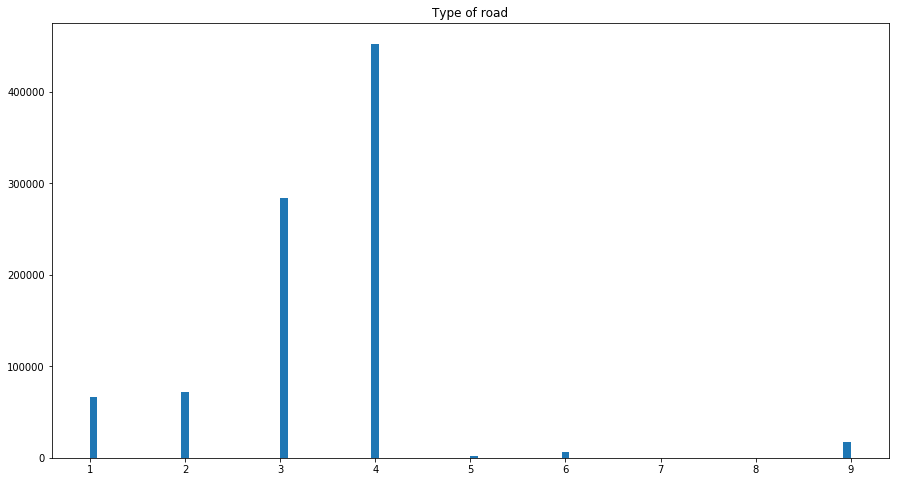

In [35]:
# Type of road
plt.figure(figsize=(15,8))
plt.hist(lie['catr'], bins=100)
plt.title('Type of road')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


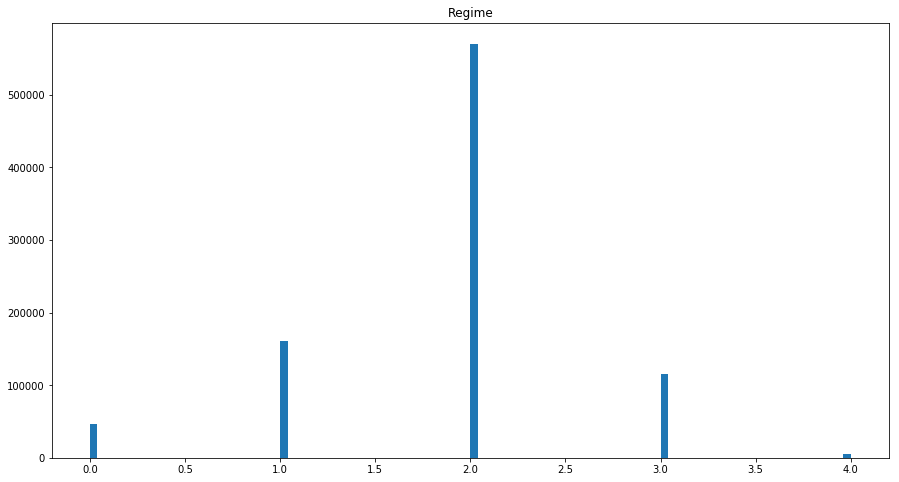

In [36]:
# Circulation Regime 
plt.figure(figsize=(15,8))
plt.hist(lie['circ'], bins=100)
plt.title('Regime')
plt.show()

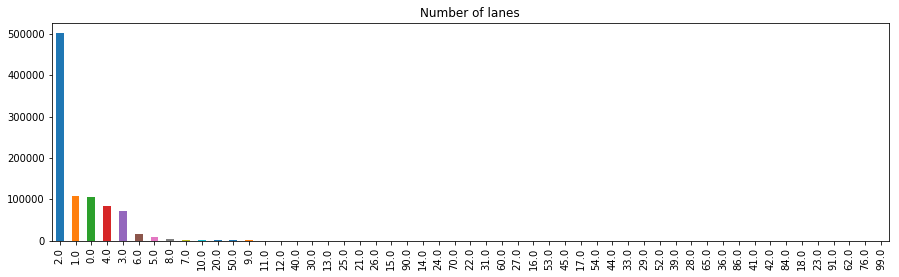

In [37]:
# Number of lanes
plt.figure(figsize=(15,4))
lie['nbv'].value_counts().plot.bar()
plt.title('Number of lanes')
plt.show()

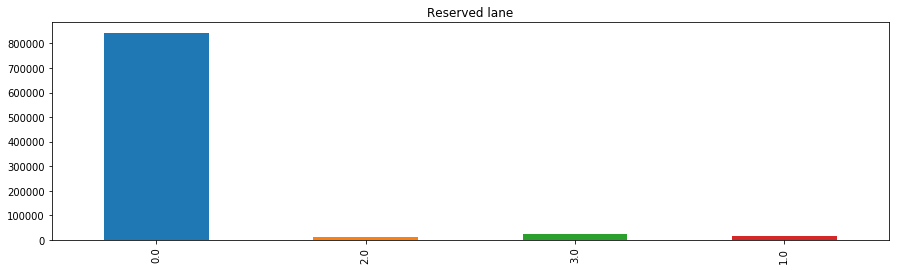

In [38]:
# Reserved lane
plt.figure(figsize=(15,4))
lie['vosp'].value_counts(sort=False).plot.bar()
plt.title('Reserved lane')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


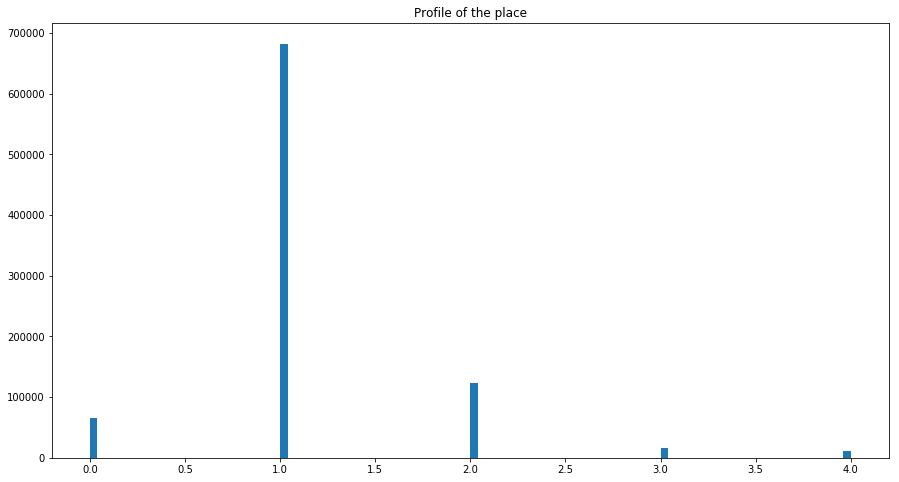

In [39]:
# Profile of the place
plt.figure(figsize=(15,8))
plt.hist(lie['prof'], bins=100)
plt.title('Profile of the place')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


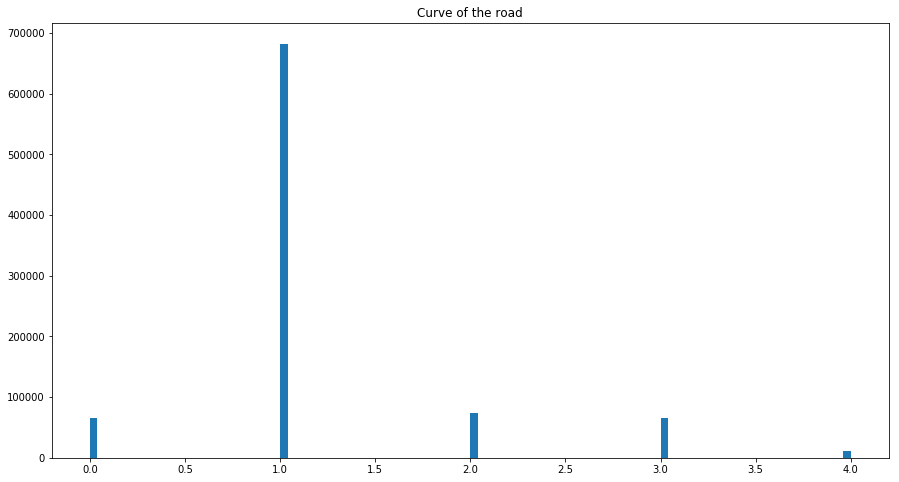

In [40]:
# Curve of the road
plt.figure(figsize=(15,8))
plt.hist(lie['plan'], bins=100)
plt.title('Curve of the road')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


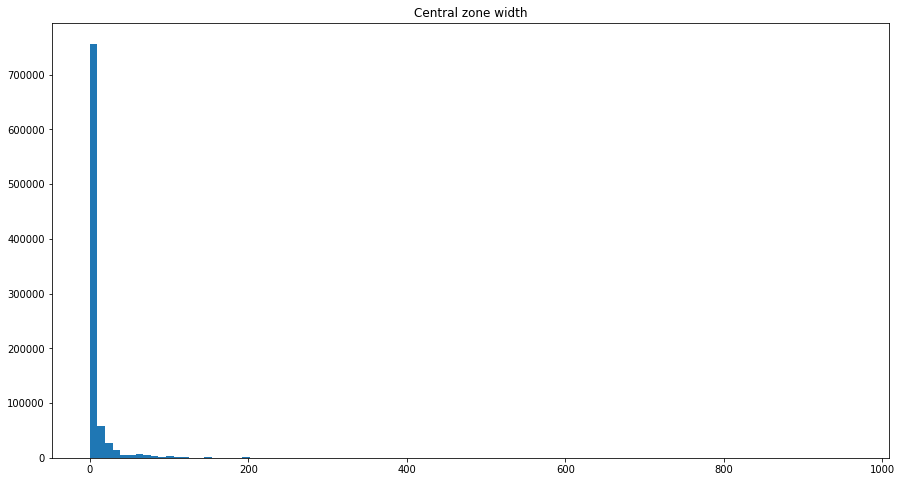

In [41]:
# Curve of the road
plt.figure(figsize=(15,8))
plt.hist(lie['lartpc'], bins=100)
plt.title('Central zone width')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


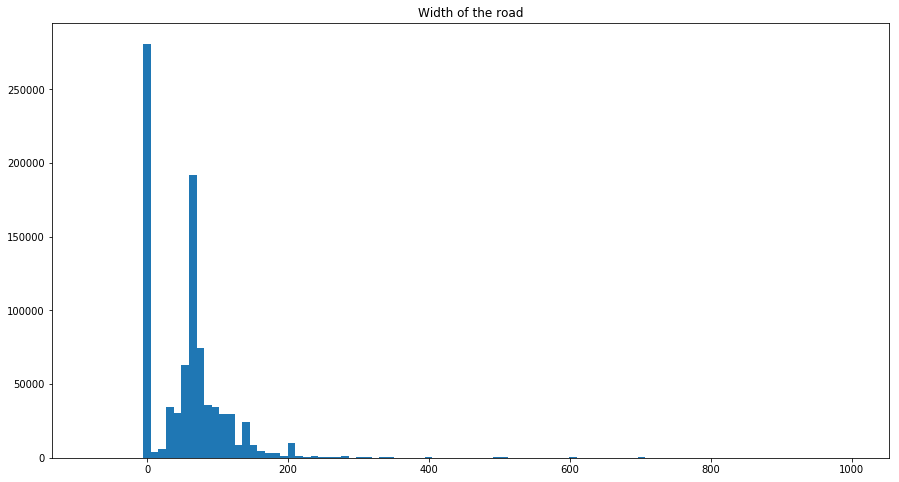

In [42]:
# Width of the road
plt.figure(figsize=(15,8))
plt.hist(lie['larrout'], bins=100)
plt.title('Width of the road')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


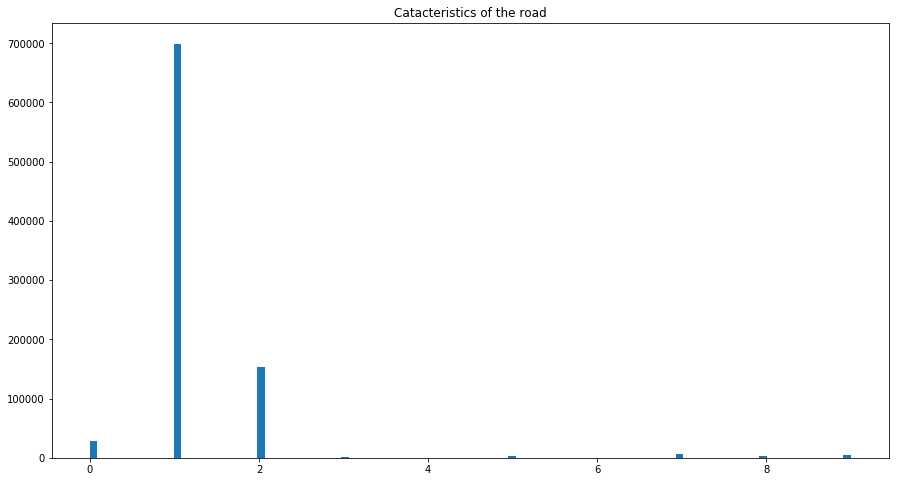

In [43]:
# Catacteristics of the road
plt.figure(figsize=(15,8))
plt.hist(lie['surf'], bins=100)
plt.title('Catacteristics of the road')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


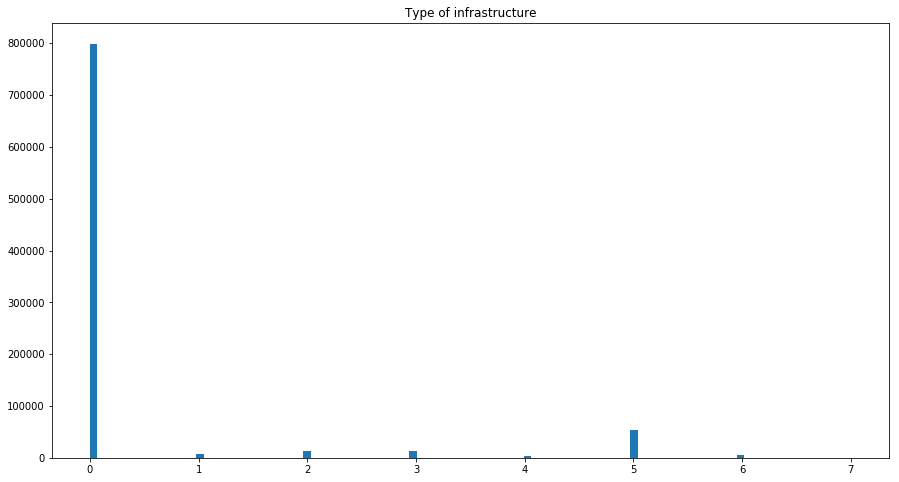

In [44]:
# Type of infrastructure
plt.figure(figsize=(15,8))
plt.hist(lie['infra'], bins=100)
plt.title('Type of infrastructure')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


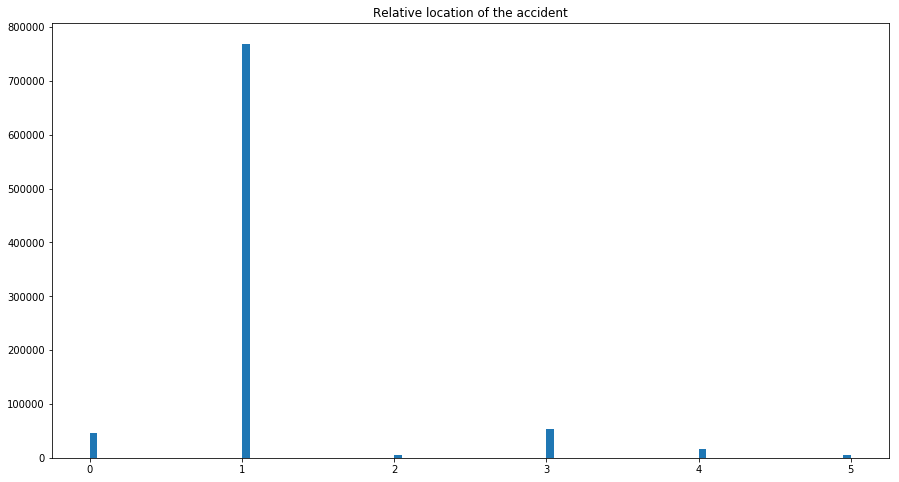

In [45]:
# Relative location of the accident
plt.figure(figsize=(15,8))
plt.hist(lie['situ'], bins=100)
plt.title('Relative location of the accident')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


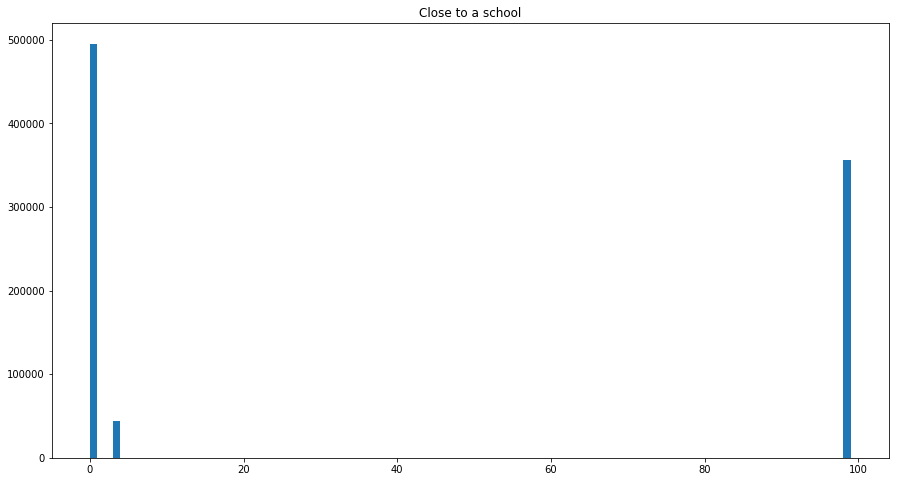

In [46]:
# Close to a school
plt.figure(figsize=(15,8))
plt.hist(lie['env1'], bins=100)
plt.title('Close to a school')
plt.show()

## 4. Caracteristics

In [47]:
car.describe()

Num_Acc             an           mois           jour  \
count  9.006860e+05  900686.000000  900686.000000  900686.000000   
mean   2.010482e+11      10.482138       6.674854      15.600558   
std    3.771189e+08       3.771238       3.388750       8.747777   
min    2.005000e+11       5.000000       1.000000       1.000000   
25%    2.007001e+11       7.000000       4.000000       8.000000   
50%    2.010000e+11      10.000000       7.000000      15.000000   
75%    2.014000e+11      14.000000      10.000000      23.000000   
max    2.017001e+11      17.000000      12.000000      31.000000   

                hrmn            lum            agg            int  \
count  900686.000000  900686.000000  900686.000000  900686.000000   
mean     1380.758373       1.912187       1.682401       1.704090   
std       541.167420       1.515692       0.465543       1.525159   
min         1.000000       1.000000       1.000000       0.000000   
25%      1000.000000       1.000000       1.000000       1.000000   
50%      1446.000000       1.000000       2.000000       1.000000   
75%      1810.000000       3.000000       2.000000       2.000000   
max      2359.000000       5.000000       2.000000       9.000000   

                 atm            col            com           lat  \
count  900618.000000  900669.000000  900684.000000  4.154410e+05   
mean        1.548866       4.188703     186.807177  3.076385e+06   
std         1.589944       1.972987     171.729738  2.222530e+06   
min         1.000000       1.000000       0.000000  0.000000e+00   
25%         1.000000       3.000000      55.000000  0.000000e+00   
50%         1.000000       3.000000     118.000000  4.449400e+06   
75%         1.000000       6.000000     278.000000  4.820171e+06   
max         9.000000       7.000000     987.000000  5.564823e+06   

                 dep  
count  900686.000000  
mean      565.172907  
std       291.418547  
min        10.000000  
25%       310.000000  
50%       630.000000  
75%       780.000000  
max       976.000000

In [48]:
car.head()

Num_Acc  an  mois  jour  hrmn  lum  agg  int  atm  col    com  \
0  200500000001   5     1    12  1900    3    2    1  1.0  3.0   11.0   
1  200500000002   5     1    21  1600    1    2    1  1.0  1.0   51.0   
2  200500000003   5     1    21  1845    3    1    1  2.0  1.0   51.0   
3  200500000004   5     1     4  1615    1    1    1  1.0  5.0   82.0   
4  200500000005   5     1    10  1945    3    1    1  3.0  6.0  478.0   

            adr gps        lat    long  dep  
0         CD41B   M  5051500.0  294400  590  
1  rue de Lille   M  5053700.0  280200  590  
2           NaN   M  5054600.0  280000  590  
3           NaN   M  5098700.0  240800  590  
4           NaN   M  5096400.0  247500  590

In [49]:
def year (y) :
    if y >= 10 :
        return str('20' + str(y))
    else :
        return str('200' + str(y))

car['date'] = pd.to_datetime(car['jour'].astype(str) + '-' + car['mois'].astype(str) + '-' + car['an'].apply(lambda x: year(x)))
car['qty'] = 1

In [72]:
import altair as alt
#from altair import *
alt.data_transformers.enable('json') #allow more than 5'000 rows

def plot_time(X, X_2, name) :

    scales = alt.selection_interval(bind='scales')

    brush = alt.selection_interval()
    
    time_1 = alt.Chart(X).mark_circle().encode(
        x=alt.X('date:N'),
        y=alt.Y('qty:Q'),
        tooltip=[
            alt.Tooltip('qty:Q', title="Quantity"),
            alt.Tooltip('date:N', title="Date")
        ]
    ).properties(
        width=700,
        height=300
    ).add_selection(
        scales
    ).properties(
        title="Number of accidents per day"
    ).transform_filter(
        brush
    )

    time_lower = time_1.properties(
        height=60
    ).add_selection(brush)

    time = alt.vconcat(time_1, time_lower)
    
    
    time_2 = alt.Chart(X_2).mark_circle(color='red',).encode(
        x=alt.X('date:N'),
        y=alt.Y('qty:Q'),
        tooltip=[
            alt.Tooltip('qty:Q', title="Quantity"),
            alt.Tooltip('date:N', title="Date")
        ]
    )
    
    chart = alt.Chart(usa.sample(8000)).mark_bar().encode(
        alt.X("age:Q", bin=alt.Bin(maxbins=100), axis=alt.Axis(title='Age')),
        y='count()',
        tooltip=[alt.Tooltip('count()', title="Total")],
    ).properties(
        title='Age of the victims',
        width=400,
        height=300
    )

    chart.save('histo_age.html')

    chart_full = chart | time + time_2
    
    return chart_full.save(name)

In [58]:
#X_3 = pd.read_csv('zone_df.csv')
X_2 = pd.DataFrame(car.groupby('date').sum()['qty'].rolling(window=365).mean()).reset_index().dropna()
X = pd.DataFrame(car.groupby('date').sum()['qty']).reset_index()

In [73]:
plot_time(X, X_2, 'explo_var.html')

/anaconda3/lib/python3.6/site-packages/altair/vegalite/v2/api.py:97: UserWarning: data of type <class 'type'> not recognized
  warnings.warn("data of type {} not recognized".format(type(data)))
/anaconda3/lib/python3.6/site-packages/altair/vegalite/v2/api.py:97: UserWarning: data of type <class 'type'> not recognized
  warnings.warn("data of type {} not recognized".format(type(data)))
/anaconda3/lib/python3.6/site-packages/altair/vegalite/v2/api.py:97: UserWarning: data of type <class 'type'> not recognized
  warnings.warn("data of type {} not recognized".format(type(data)))
/anaconda3/lib/python3.6/site-packages/altair/vegalite/v2/api.py:97: UserWarning: data of type <class 'type'> not recognized
  warnings.warn("data of type {} not recognized".format(type(data)))
/anaconda3/lib/python3.6/site-packages/altair/vegalite/v2/api.py:97: UserWarning: data of type <class 'type'> not recognized
  warnings.warn("data of type {} not recognized".format(type(data)))
/anaconda3/lib/python3.6/site-

SchemaValidationError: Invalid specification

        altair.vegalite.v2.api.Chart->data, validating 'anyOf'

        <class 'altair.vegalite.v2.schema.channels.X'> is not valid under any of the given schemas
        

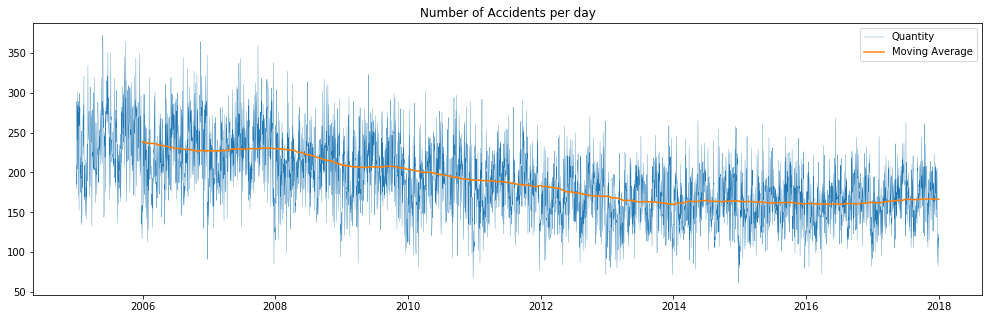

In [85]:
plt.figure(figsize=(17,5))
plt.plot(car.groupby('date').sum()['qty'], linewidth=0.3, label="Quantity")
plt.plot(car.groupby('date').sum()['qty'].rolling(window=365).mean(), label='Moving Average')
plt.title('Number of Accidents per day')
plt.legend()
plt.show()

In [ ]:
chart = alt.Chart(usa.sample(4999)).mark_bar().encode(
    alt.X("age:Q", axis=alt.Axis(title='Age')),
    y='count()',
    tooltip=[alt.Tooltip('count()', title="Total")],
).properties(
    title='Age of the victims'
)

chart.save('histo_age.html')

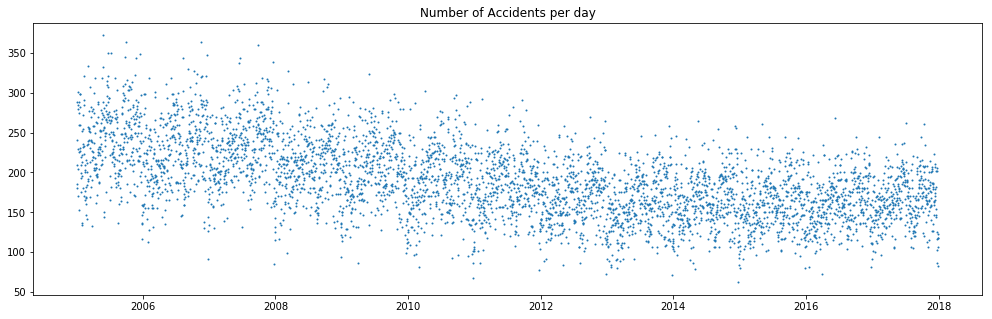

In [86]:
plt.figure(figsize=(17,5))
plt.scatter(car.groupby('date').sum().index, car.groupby('date').sum()['qty'], s=1)
plt.title('Number of Accidents per day')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

fig = sm.graphics.tsa.plot_acf(car.groupby('date').sum()['qty'], lags=365, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(car.groupby('date').sum()['qty'], lags=365, ax=axes[1])

In [ ]:
decomposition = seasonal_decompose(car.groupby('date').sum()['qty'], freq=365)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

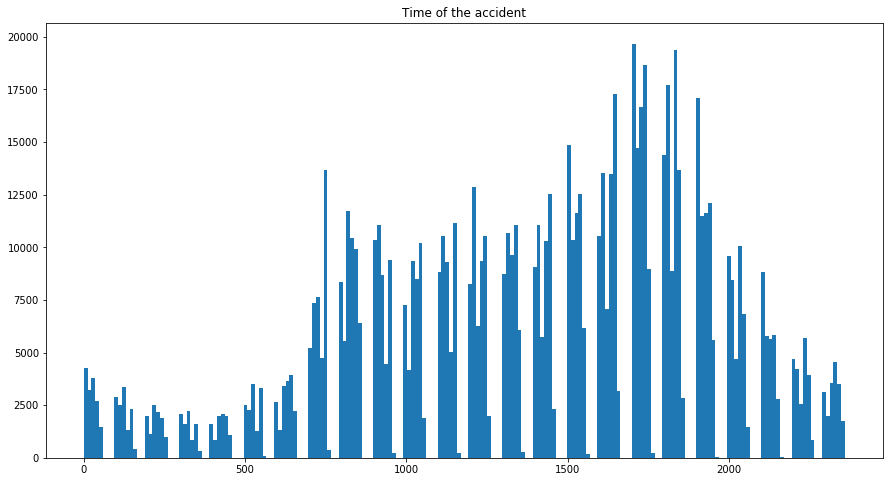

In [61]:
# Time of the accident
plt.figure(figsize=(15,8))
plt.hist(car['hrmn'], bins=200)
plt.title('Time of the accident')
plt.show()

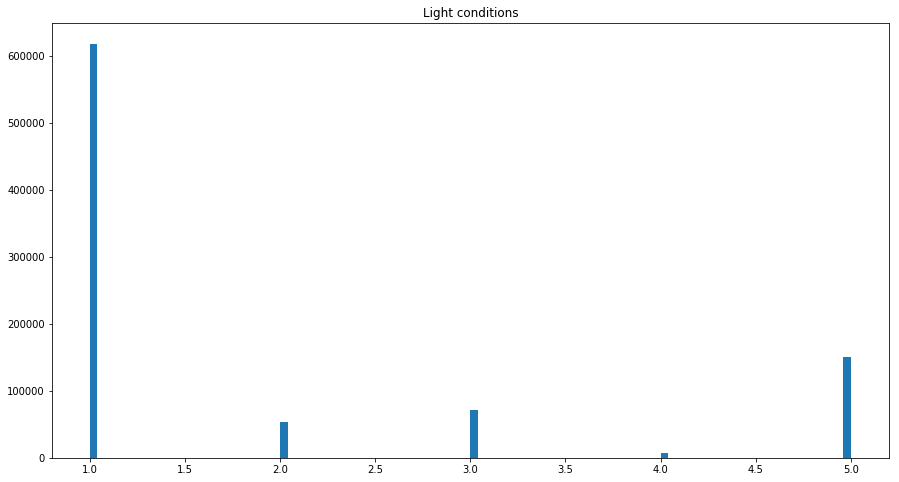

In [62]:
# Light conditions
plt.figure(figsize=(15,8))
plt.hist(car['lum'], bins=100)
plt.title('Light conditions')
plt.show()

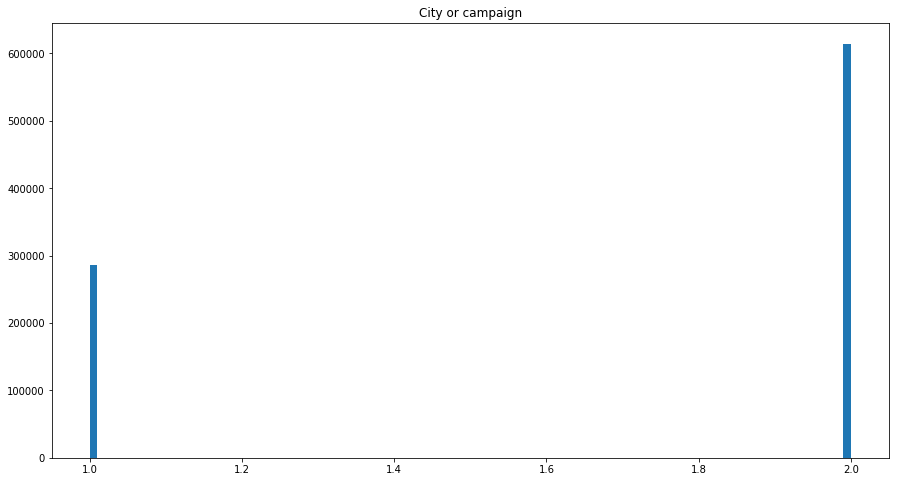

In [63]:
# In the City
plt.figure(figsize=(15,8))
plt.hist(car['agg'], bins=100)
plt.title('City or campaign')
plt.show()

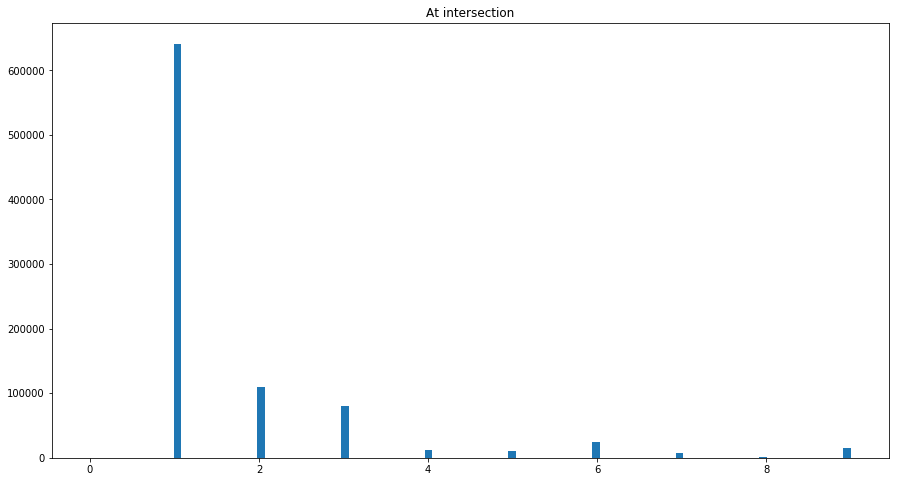

In [64]:
# At intersection
plt.figure(figsize=(15,8))
plt.hist(car['int'], bins=100)
plt.title('At intersection')
plt.show()

/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


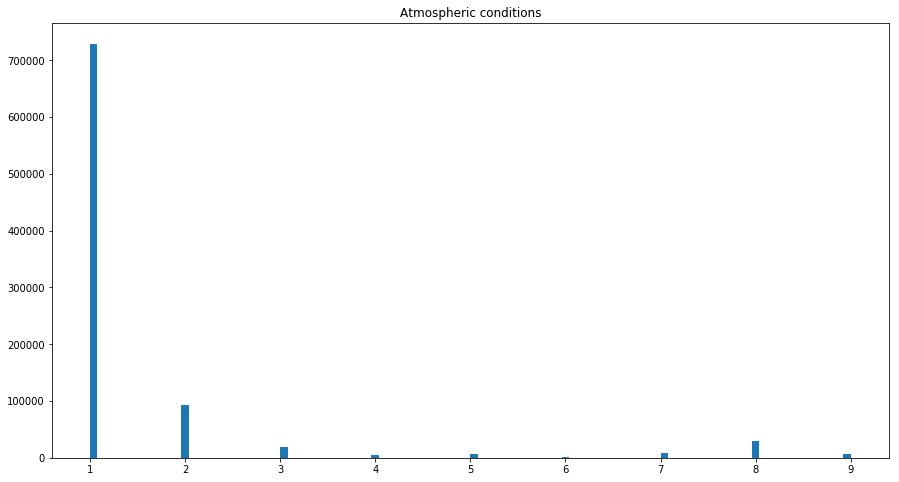

In [65]:
# Atmospheric condition
plt.figure(figsize=(15,8))
plt.hist(car['atm'], bins=100)
plt.title('Atmospheric conditions')
plt.show()

/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


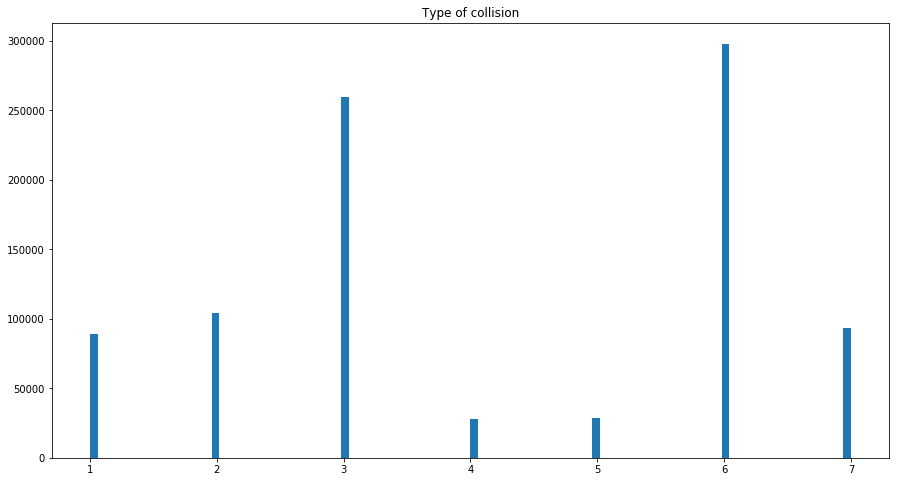

In [66]:
# Type of collision
plt.figure(figsize=(15,8))
plt.hist(car['col'], bins=100)
plt.title('Type of collision')
plt.show()

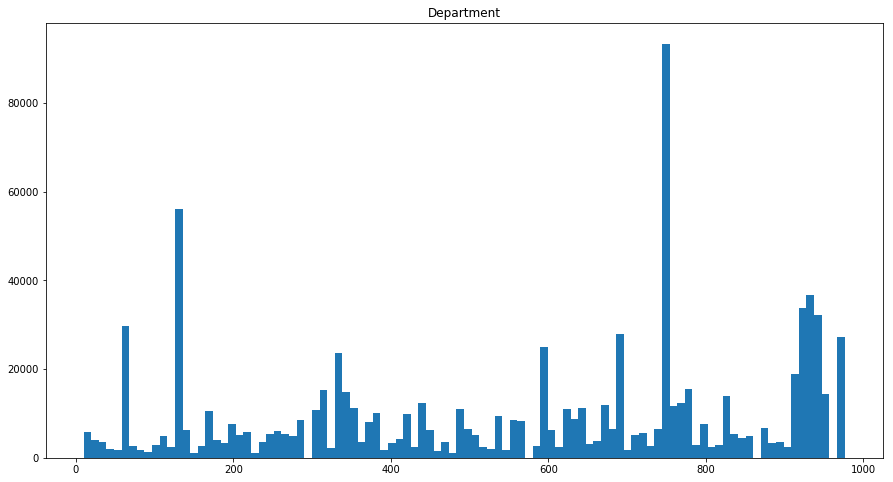

In [67]:
# Department
plt.figure(figsize=(15,8))
plt.hist(car['dep'], bins=100)
plt.title('Department')
plt.show()

In [68]:
car['long'] = car['long'].replace('-', 0).fillna(0).astype('int')
car['lat'] = car['lat'].replace('-', 0).fillna(0).astype('int')
car_met = car[(car['long']<2000000) & (car['lat'] > 3000000) & (car['lat'] < 5200000)]
car_met['atm'] = car_met['atm'].fillna(0)
car_met['col'] = car_met['col'].fillna(0)

/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


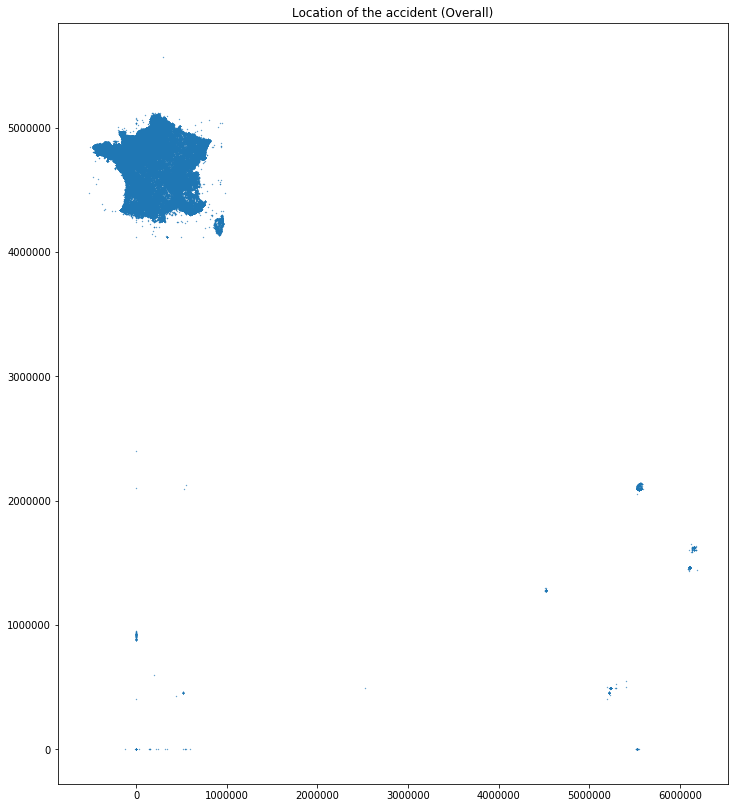

In [69]:
# Accident location
plt.figure(figsize=(12,14))
plt.scatter(car[car['long'] < 10000000]['long'], car[car['long'] < 10000000]['lat'], s=0.1)
plt.title('Location of the accident (Overall)')
plt.show()

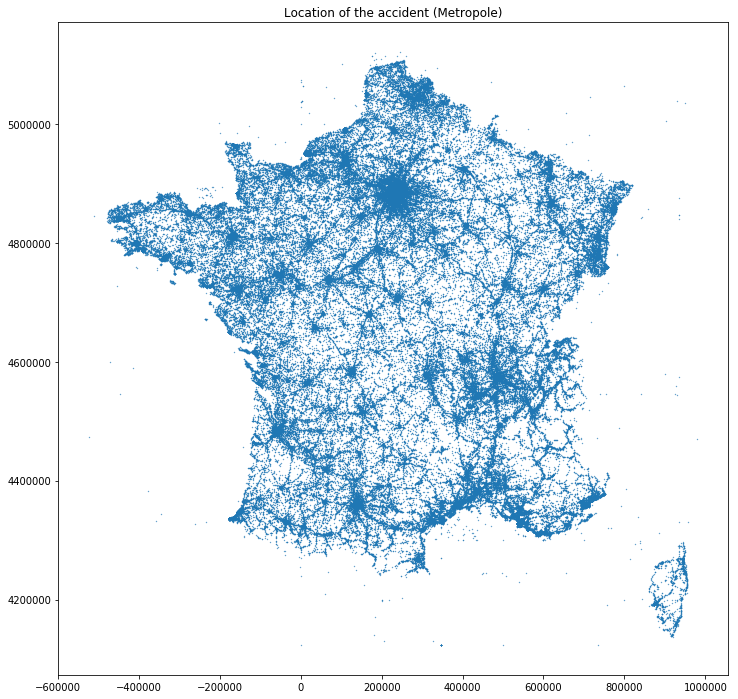

In [70]:
# Accident location
plt.figure(figsize=(12,12))
plt.scatter(car_met['long'], car_met['lat'], s=0.1)
plt.title('Location of the accident (Metropole)')
plt.show()

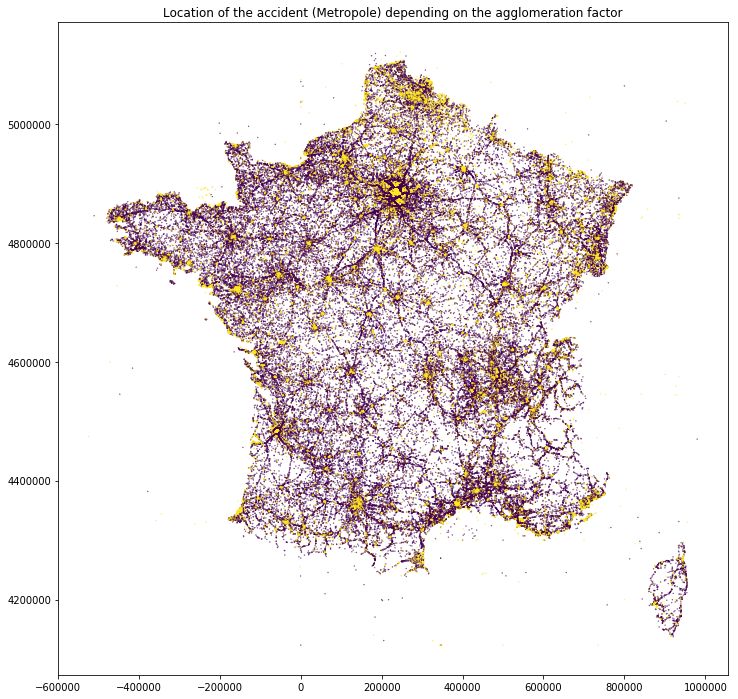

In [71]:
# Accident location, depending on agglomeration
plt.figure(figsize=(12,12))
plt.scatter(car_met['long'], car_met['lat'], c=set_color(car_met, 'agg'), s=0.1)
plt.title('Location of the accident (Metropole) depending on the agglomeration factor')
plt.show()

In [ ]:
# Accident location, depending on light conditions
plt.figure(figsize=(12,12))
plt.scatter(car_met['long'], car_met['lat'], c=set_color(car_met, 'lum'), s=0.1)
plt.title('Location of the accident (Metropole) depending on light conditions')
plt.show()

In [ ]:
# Accident location, depending on atmospheric conditions
plt.figure(figsize=(12,12))
plt.scatter(car_met['long'], car_met['lat'], c=set_color(car_met, 'atm'), s=0.1)
plt.title('Location of the accident (Metropole) depending on atmospheric conditions')
plt.show()

In [ ]:
# Accident location, depending on type of collision
plt.figure(figsize=(12,12))
plt.scatter(car_met['long'], car_met['lat'], c=set_color(car_met, 'col'), s=0.1)
plt.title('Location of the accident (Metropole) depending on type of collission')
plt.show()

## 5. Mix Caracteristic and Location

In [ ]:
car_loc = pd.concat([lie, car], axis=1)
car_loc_met = car_loc[(car_loc['long']<2000000) & (car_loc['lat'] > 3000000) & (car_loc['lat'] < 5200000)]
car_loc_met['circ'] = car_loc_met['circ'].fillna(0)
car_loc_met['env1'] = car_loc_met['env1'].fillna(0)
car_loc_met['larrout'] = car_loc_met['larrout'].fillna(0)

In [ ]:
# Accident location, close to school
plt.figure(figsize=(12,12))
plt.scatter(car_loc_met['long'], car_loc_met['lat'], c=set_color(car_loc_met, 'env1'), s=0.1)
plt.title('Location of the accident (Metropole), close to school or not')
plt.show()

In [ ]:
# Accident location depending on road width
plt.figure(figsize=(12,12))
plt.scatter(car_loc_met['long'], car_loc_met['lat'], car_loc_met['larrout']/15)
plt.title('Location of the accident (Metropole), depending on width of road')
plt.show()

In [ ]:
# Accident location depending on number of lanes
plt.figure(figsize=(12,12))
plt.scatter(car_loc_met['long'], car_loc_met['lat'], car_loc_met['nbv'])
plt.title('Location of the accident (Metropole), depending on number of lanes')
plt.show()

In [ ]:
# Accident location depending on type of road
plt.figure(figsize=(12,12))
plt.scatter(car_loc_met['long'], car_loc_met['lat'], c=set_color(car_loc_met, 'catr'), s=0.1)
plt.title('Location of the accident (Metropole), depending on type of road')
plt.show()

In [ ]:
# Accident location depending on circulation regime
plt.figure(figsize=(12,12))
plt.scatter(car_loc_met['long'], car_loc_met['lat'], c=set_color(car_loc_met, 'circ'), s=0.1)
plt.title('Location of the accident (Metropole), depending on type of road')
plt.show()

## 6. Mix Vehicule and Caracteristics

In [73]:
veh_car = pd.merge(veh, car, on='Num_Acc')
veh_car_met = veh_car[(veh_car['long']<2000000) & (veh_car['lat'] > 3000000) & (veh_car['lat'] < 5200000)]
veh_car_met['choc'] = veh_car_met['choc'].fillna(0)
veh_car_met['obsm'] = veh_car_met['obsm'].fillna(0)
veh_car_met['obs'] = veh_car_met['obs'].fillna(0)

/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be se

In [ ]:
# Number of victims
plt.figure(figsize=(12,12))
plt.scatter(veh_car_met['long'], veh_car_met['lat'], veh_car_met['occutc']*8)
plt.title('Location of the accident (Metropole), depending on number of victims')
plt.show()

In [ ]:
# Vehicle Category
plt.figure(figsize=(12,12))
plt.scatter(veh_car_met['long'], veh_car_met['lat'], c=set_color(veh_car_met, 'catv'), s=0.1)
plt.title('Location of the accident (Metropole), depending on vehicle category')
plt.show()

In [ ]:
# Part of vehicle damaged
plt.figure(figsize=(12,12))
plt.scatter(veh_car_met['long'], veh_car_met['lat'], c=set_color(veh_car_met, 'choc'), s=0.1)
plt.title('Location of the accident (Metropole), depending on part of vehicle damages')
plt.show()

In [ ]:
# Mobile obstacle
plt.figure(figsize=(12,12))
plt.scatter(veh_car_met['long'], veh_car_met['lat'], c=set_color(veh_car_met, 'obsm'), s=0.1)
plt.title('Location of the accident (Metropole), depending on mobile obstacle')
plt.show()

In [ ]:
# Fixed obstacle
plt.figure(figsize=(12,12))
plt.scatter(veh_car_met['long'], veh_car_met['lat'], c=set_color(veh_car_met, 'obs'), s=0.1)
plt.title('Location of the accident (Metropole), depending on fixed obstacle')
plt.show()

## 7. Mixing Users and Caracteristics

In [ ]:
usa_car = pd.merge(usa, car, on='Num_Acc')
usa_car_met = usa_car[(usa_car['long']<2000000) & (usa_car['lat'] > 3000000) & (usa_car['lat'] < 5200000)]
usa_car_met['age'] = usa_car_met['age'].fillna(0)
usa_car_met['secu'] = usa_car_met['secu'].fillna(0)

In [ ]:
# Sex of the person
plt.figure(figsize=(12,12))
plt.scatter(usa_car_met['long'], usa_car_met['lat'], c=set_color(usa_car_met, 'sexe'), s=0.1)
plt.title('Location of the accident (Metropole), depending on sex of the person')
plt.show()

In [ ]:
# Age of the person
plt.figure(figsize=(12,12))
plt.scatter(usa_car_met['long'], usa_car_met['lat'], usa_car_met['age']/100)
plt.title('Location of the accident (Metropole), depending on age of the person')
plt.show()

In [ ]:
# Deaths on the road
plt.figure(figsize=(12,12))
plt.scatter(usa_car_met['long'], usa_car_met['lat'], s=0.2)
plt.scatter(usa_car_met[usa_car_met['grav'] == 2]['long'], usa_car_met[usa_car_met['grav'] == 2]['lat'], s=0.2)
plt.title('Location of the accident (Metropole), deadliest zones')
plt.show()

In [ ]:
# Deaths on the road
plt.figure(figsize=(12,12))
plt.scatter(usa_car_met[usa_car_met['grav'] == 2]['long'], usa_car_met[usa_car_met['grav'] == 2]['lat'], s=0.2)
plt.title('Location of the accident (Metropole), deaths')
plt.show()

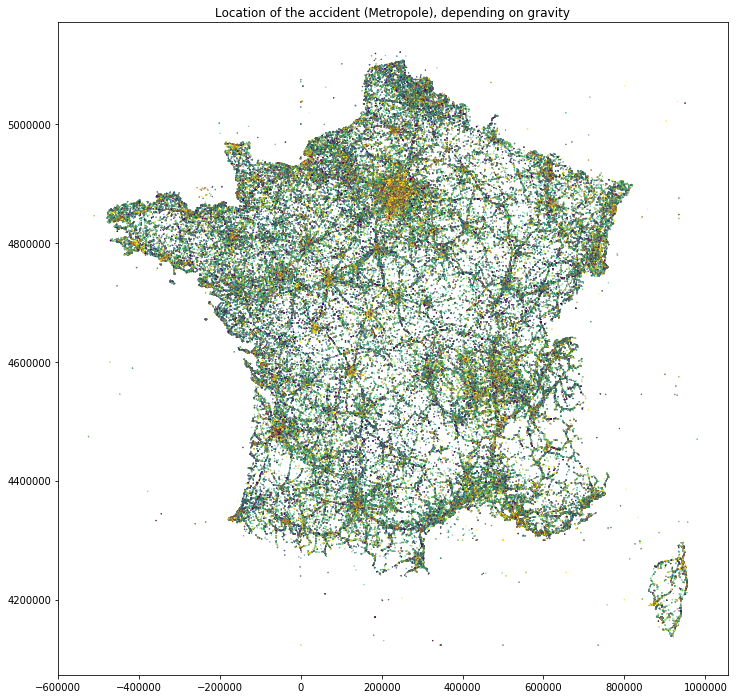

In [83]:
# Gravity of the accident
plt.figure(figsize=(12,12))
plt.scatter(usa_car_met['long'], usa_car_met['lat'], c=set_color(usa_car_met, 'grav'), s=0.1)
plt.title('Location of the accident (Metropole), depending on gravity')
plt.show()

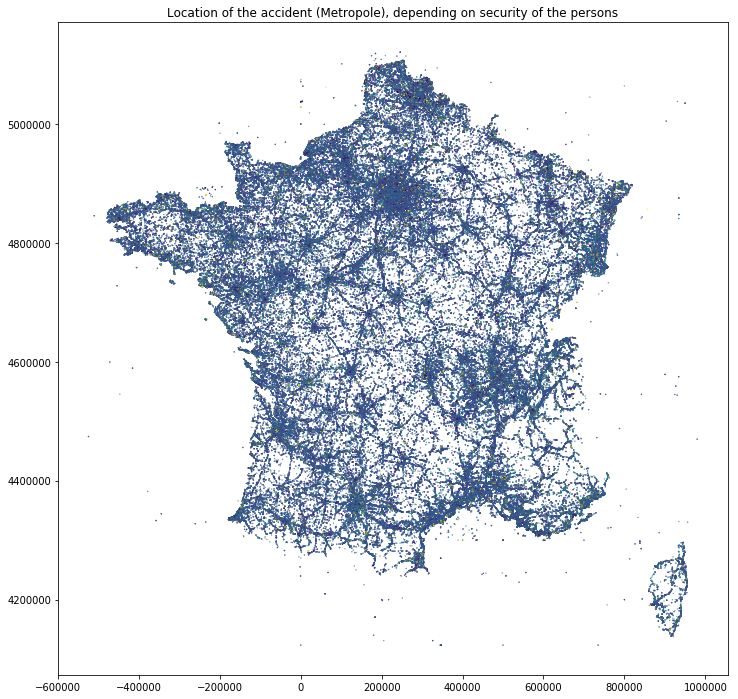

In [84]:
# Security of the persons
plt.figure(figsize=(12,12))
plt.scatter(usa_car_met['long'], usa_car_met['lat'], c=set_color(usa_car_met, 'secu'), s=0.1)
plt.title('Location of the accident (Metropole), depending on security of the persons')
plt.show()

## 8. Focus on Paris

In [86]:
veh_car = pd.merge(veh, car, on='Num_Acc')

veh_car['long'] = veh_car['long'].apply(pd.to_numeric, errors='coerce')
veh_car['lat'] = veh_car['lat'].apply(pd.to_numeric, errors='coerce')

print(veh_car[['long', 'lat']].head())

veh_car_paris = veh_car[(veh_car['long'] > 233141) 
                      & (veh_car['long'] < 235673) 
                      & (veh_car['lat'] > 4882110) 
                      & (veh_car['lat'] < 4883153)]

print(veh_car_paris.head())

veh_car_paris['choc'] = veh_car_met['choc'].fillna(0)
veh_car_paris['obsm'] = veh_car_met['obsm'].fillna(0)
veh_car_paris['obs'] = veh_car_met['obs'].fillna(0)

     long      lat
0  294400  5051500
1  294400  5051500
2  280200  5053700
3  280200  5053700
4  280000  5054600
              Num_Acc  senc  catv  occutc  obs  obsm  choc  manv num_veh  nb  \
1423569  201600053634   1.0    10       0  0.0   1.0   0.0   4.0     A01   1   
1423749  201600053744   1.0    30       0  0.0   2.0   0.0  16.0     Z01   1   
1423750  201600053744   1.0     1       0  0.0   2.0   1.0   1.0     A01   1   
1423751  201600053745   1.0     7       0  0.0   1.0   1.0   1.0     A01   1   
1423757  201600053749   0.0    33       0  0.0   2.0   8.0   1.0     B01   1   

        ...   agg  int  atm  col    com                       adr  gps  \
1423569 ...     2    5  1.0  6.0  113.0       188, RUE DE TOLBIAC    M   
1423749 ...     2    5  1.0  6.0  113.0  72, BOULEVARD AUGUSTE BL    M   
1423750 ...     2    5  1.0  6.0  113.0  72, BOULEVARD AUGUSTE BL    M   
1423751 ...     2    1  2.0  6.0  113.0        4, AVENUE D ITALIE    M   
1423757 ...     2    2  1.0  3.0  1

/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [7]:
import geopandas as gpd 

In [8]:
veh_car = pd.merge(veh, car, on='Num_Acc')

veh_car['long'] = veh_car['long'].apply(pd.to_numeric, errors='coerce')
veh_car['lat'] = veh_car['lat'].apply(pd.to_numeric, errors='coerce')

gdf = gpd.GeoDataFrame(
    veh_car, 
    geometry=gpd.points_from_xy(veh_car.long, veh_car.lat))

In [9]:
gdf.head()
# cities.plot(ax=base, marker='o', color='red', markersize=5);

Num_Acc  senc  catv  occutc  obs  obsm  choc  manv num_veh  an  \
0  200500000001   0.0     7       0  0.0   2.0   1.0   1.0     A01   5   
1  200500000001   0.0     7       0  0.0   2.0   8.0  10.0     B02   5   
2  200500000002   0.0     7       0  0.0   2.0   7.0  16.0     A01   5   
3  200500000002   0.0     2       0  0.0   2.0   1.0   1.0     B02   5   
4  200500000003   0.0     2       0  0.0   2.0   1.0   1.0     A01   5   

            ...            int  atm  col   com           adr  gps        lat  \
0           ...              1  1.0  3.0  11.0         CD41B    M  5051500.0   
1           ...              1  1.0  3.0  11.0         CD41B    M  5051500.0   
2           ...              1  1.0  1.0  51.0  rue de Lille    M  5053700.0   
3           ...              1  1.0  1.0  51.0  rue de Lille    M  5053700.0   
4           ...              1  2.0  1.0  51.0           NaN    M  5054600.0   

       long  dep                geometry  
0  294400.0  590  POINT (294400 5051500)  
1  294400.0  590  POINT (294400 5051500)  
2  280200.0  590  POINT (280200 5053700)  
3  280200.0  590  POINT (280200 5053700)  
4  280000.0  590  POINT (280000 5054600)  

[5 rows x 25 columns]

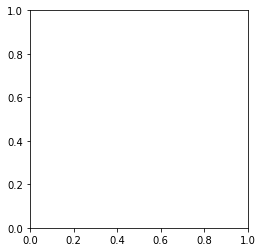

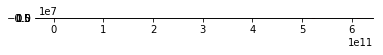

In [16]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', color='red', markersize=5)

plt.show()

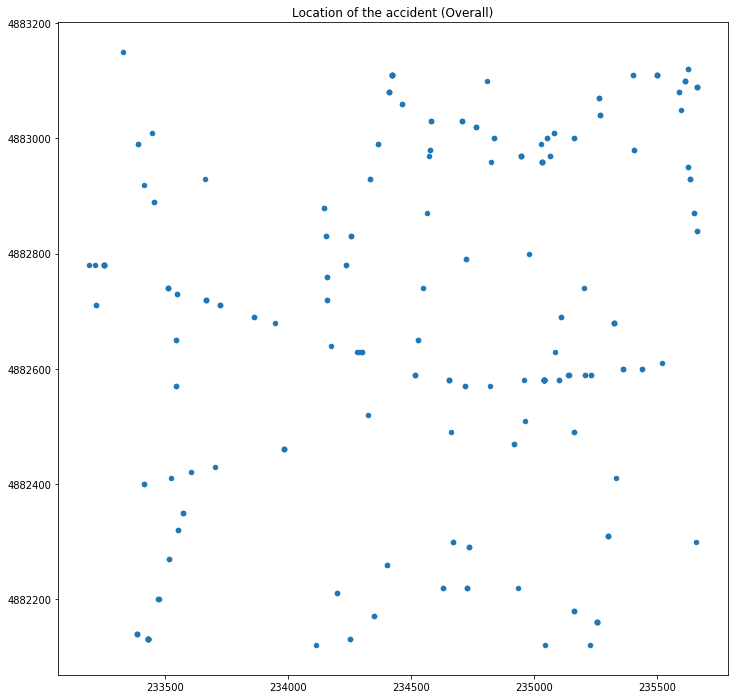

In [92]:
# Accident location
plt.figure(figsize=(12,12))
plt.scatter(veh_car_paris['long'], veh_car_paris['lat'], s=20)
plt.title('Location of the accident (Overall)')
plt.show()

## 9. Viz on map

In [19]:
# Filtering on area code
city_codes = pd.read_csv('France2018-city-codes.txt', 
                         header=0, 
                         sep='\t', 
                         error_bad_lines=False,
                         encoding='cp850',
                         usecols=['COM', 'NCC'])

city_codes[0:5]

COM                    NCC
0    1  ABERGEMENT-CLEMENCIAT
1    2    ABERGEMENT-DE-VAREY
2    3               AMAREINS
3    4      AMBERIEU-EN-BUGEY
4    5    AMBERIEUX-EN-DOMBES

In [20]:
# Filtre sur le code commune
# https://www.insee.fr/fr/information/3363419

veh_car = pd.merge(veh, car, on='Num_Acc')
veh_car_paris = veh_car[(veh_car['com'] == 101)]

print(veh_car_paris.shape[0], ' rows for dept 750.')

veh_car_paris = veh_car_paris[veh_car_paris.long != 0]

print(veh_car_paris.shape[0], ' rows with gps cordinates.\n')

veh_car_paris['lat_folium'] = veh_car_paris['lat'] / 100000
veh_car_paris['long_folium'] = veh_car_paris['long'] / 100000
veh_car_paris = veh_car_paris.drop(['lat', 'long'], axis=1)

print(veh_car_paris[['com', 'lat_folium', 'long_folium']].head())

NameError: name 'veh' is not defined

In [152]:
# Create map and center it
map_osm = folium.Map(location=[48.85, 2.34])

for ind, lat, lon in veh_car_paris[['lat_folium', 'long_folium']].itertuples():
    map_osm.add_child(folium.RegularPolygonMarker(
        location=[lat,lon],
        fill_color='#132b5e', 
        radius=1))

map_osm